# Project Title: Forecasting Inventory of Steel Rods

**Business Problem:** Excess steel inventory is hurting profits.

**Business Objectives:** Minimize excess steel inventory to improve profitability.

**Business Constraints:** Maximize production efficiency.


**Success Criteria:**

**Business Success Criteria:** Reduce steel inventory by 10% to 12% over the next 5 years.

**ML Success Criteria:** Achieve less than 15% error value in the forecasted inventory levels over the next 5 years.

**Economic Success Criteria:** Increase profits by $1 million to $1.2 million over the next 5 years, as compared to the previous 5 years average profits.

# **Importing libraries**

In [1]:
import pandas as pd                            # Data Manipulation
import numpy as np                             # Arthimetic Operations
import matplotlib.pyplot as plt                # Data Visualizations
import seaborn as sns                          # Advanced Data Visualizations
import scipy.stats as stats                    # Scientific Calculations
import psycopg2
from sklearn.impute import SimpleImputer       # Imputation
from sklearn.pipeline import Pipeline          # Creating Pipeline
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

# Train and Test split
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Metrics calculations
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tabulate import tabulate

# Auto-EDA
import sweetviz as sv

# Saving the pipeline
import joblib

# Saving the pickle file
import pickle

# Ignoring Warning 
import warnings                   
warnings.filterwarnings('ignore')

In [2]:
# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host ="localhost",
    database = "db",
    user = "postgres",
    password = "Mahesh@1603"
)

with conn.cursor() as cur:
    cur.execute("SELECT * FROM steel_rods")
    rows = cur.fetchall()
    for row in rows:
        print(row)
data = pd.DataFrame(rows, columns = ["Date", "Time", "Location", "Sales_in_Rs_per_T", "Sales_volume_in_Tonnes", 
                                     "Price_per_kg", "Climate", "Customer_ID", "Diameter", "Length",
                                     "Grade", "Current_stock", "Re_order", "Lead_time", "Production_time",
                                     "Units_Produced", "Production_cost"])

(datetime.date(1995, 10, 14), datetime.time(11, 8), 'Pune', 424440, Decimal('7.07'), 60, 'Rainy', 'C9D3791C', 32, 13, 'Fe-500', 10770, 618, 7, 3, 14828, 18734)
(datetime.date(1995, 10, 15), datetime.time(10, 7), 'Hyderabad', 426000, Decimal('8.35'), 51, 'Rainy', 'F515841D', 12, 7, 'Fe-415', 8039, 1195, 2, 3, 12795, 21294)
(datetime.date(1995, 10, 16), datetime.time(17, 25), 'Kolkata', 429360, Decimal('6.82'), 63, 'Rainy', 'B387F82E', 12, 9, 'Fe-500D', 7328, 1372, 14, 6, 13576, 19759)
(datetime.date(1995, 10, 17), datetime.time(10, 0), 'Bengaluru', 432000, Decimal('6.86'), 63, 'Rainy', 'A8EBB29A', 8, 25, 'Fe-550', 3040, 688, 14, 2, 8060, 23073)
(datetime.date(1995, 10, 18), datetime.time(16, 39), 'Delhi', 432000, Decimal('7.45'), 58, 'Rainy', 'DC1D8CD9', 32, 27, 'Fe-500', 9011, 704, 11, 6, 7532, 19986)
(datetime.date(1995, 10, 19), datetime.time(13, 14), 'Hyderabad', 4158, Decimal('6.65'), 65, 'Rainy', '2DBE6340', 8, 7, 'Fe-550D', 3988, 925, 14, 6, 11513, 17307)
(datetime.date(1995, 10,

In [3]:
data.head()

Date      Time   Location  Sales_in_Rs_per_T Sales_volume_in_Tonnes  \
0  1995-10-14  11:08:00       Pune           424440.0                   7.07   
1  1995-10-15  10:07:00  Hyderabad           426000.0                   8.35   
2  1995-10-16  17:25:00    Kolkata           429360.0                   6.82   
3  1995-10-17  10:00:00  Bengaluru           432000.0                   6.86   
4  1995-10-18  16:39:00      Delhi           432000.0                   7.45   

   Price_per_kg Climate Customer_ID  Diameter  Length    Grade  Current_stock  \
0          60.0   Rainy    C9D3791C      32.0      13   Fe-500          10770   
1          51.0   Rainy    F515841D      12.0       7   Fe-415           8039   
2          63.0   Rainy    B387F82E      12.0       9  Fe-500D           7328   
3          63.0   Rainy    A8EBB29A       8.0      25   Fe-550           3040   
4          58.0   Rainy    DC1D8CD9      32.0      27   Fe-500           9011   

   Re_order  Lead_time  Production_time  Units_Produced  Production_cost  
0       618          7                3           14828            18734  
1      1195          2                3           12795            21294  
2      1372         14                6           13576            19759  
3       688         14                2            8060            23073  
4       704         11                6            7532            19986

In [4]:
data.tail() # Reading the last 5 columns

Date      Time Location  Sales_in_Rs_per_T Sales_volume_in_Tonnes  \
9995  2023-02-24  12:51:00     Pune           509579.0                   9.13   
9996  2023-02-25  11:08:00    Delhi           612511.0                   9.99   
9997  2023-02-26  17:19:00  Kolkata           672718.0                   8.84   
9998  2023-02-27  15:32:00  Kolkata           480401.0                   7.64   
9999  2023-02-28  15:46:00  Kolkata           714667.0                  10.61   

      Price_per_kg Climate Customer_ID  Diameter  Length    Grade  \
9995          52.0  Winter    94CE748E       9.0      19  Fe-500D   
9996          53.0  Winter    EE75A871      16.0      27  Fe-600D   
9997          70.0   Sunny    D3B1B31D      19.0      18  Fe-550D   
9998          66.0  Winter    1A6708FC      26.0      20     None   
9999           NaN   Sunny    E6D78E95      26.0      29  Fe-600D   

      Current_stock  Re_order  Lead_time  Production_time  Units_Produced  \
9995           3695      1206         14                6            7434   
9996           7225      1492          8                4           10847   
9997          12102       609          8                1           12405   
9998          13109       805          5                7           13980   
9999          14028       737          3                2            9064   

      Production_cost  
9995            17790  
9996            22642  
9997            23116  
9998            19983  
9999            16895

In [5]:
data.shape

(10000, 17)

In [6]:
from datetime import datetime

start_date = datetime(1995, 10, 14)
end_date = datetime(2023, 2, 28)

delta = end_date - start_date

years = delta.days // 365
months = (delta.days % 365) // 30

print("Data covers {} years and {} months".format(years, months))


Data covers 27 years and 4 months


In [7]:
data.shape # There are 10000 rows and 17 columns

(10000, 17)

In [8]:
# let's see what are the list of columns exist in our dataset
data.columns  

Index(['Date', 'Time', 'Location', 'Sales_in_Rs_per_T',
       'Sales_volume_in_Tonnes', 'Price_per_kg', 'Climate', 'Customer_ID',
       'Diameter', 'Length', 'Grade', 'Current_stock', 'Re_order', 'Lead_time',
       'Production_time', 'Units_Produced', 'Production_cost'],
      dtype='object')

In [9]:
# Descriptive Statistics for numerical columns
data.describe().T  

count           mean           std      min        25%  \
Sales_in_Rs_per_T   9992.0  541320.140112  75223.368004   4158.0  481218.00   
Price_per_kg        9995.0      62.958179      6.472928     50.0      58.00   
Diameter            9998.0      16.974995      6.467049      8.0      12.00   
Length             10000.0      17.930300      8.123869      4.0      11.00   
Current_stock      10000.0    8991.488900   3420.646321   3003.0    6045.75   
Re_order           10000.0     999.154800    285.957747    502.0     753.00   
Lead_time          10000.0       8.011000      4.049953      1.0       5.00   
Production_time    10000.0       4.035200      1.783726      1.0       3.00   
Units_Produced     10000.0   10921.567000   2288.349041   6017.0    8957.75   
Production_cost    10000.0   20079.277400   2854.058653  15004.0   17670.75   

                        50%        75%       max  
Sales_in_Rs_per_T  536157.0  594403.75  717230.0  
Price_per_kg           63.0      68.00      74.0  
Diameter               16.0      21.00      32.0  
Length                 18.0      25.00      32.0  
Current_stock        9080.0   11919.50   14989.0  
Re_order              999.0    1245.00    1500.0  
Lead_time               8.0      11.00      15.0  
Production_time         4.0       6.00       7.0  
Units_Produced      10886.5   12883.00   15800.0  
Production_cost     20150.5   22524.00   25000.0

In [10]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10000 non-null  object 
 1   Time                    9989 non-null   object 
 2   Location                9994 non-null   object 
 3   Sales_in_Rs_per_T       9992 non-null   float64
 4   Sales_volume_in_Tonnes  9992 non-null   object 
 5   Price_per_kg            9995 non-null   float64
 6   Climate                 9991 non-null   object 
 7   Customer_ID             10000 non-null  object 
 8   Diameter                9998 non-null   float64
 9   Length                  10000 non-null  int64  
 10  Grade                   9995 non-null   object 
 11  Current_stock           10000 non-null  int64  
 12  Re_order                10000 non-null  int64  
 13  Lead_time               10000 non-null  int64  
 14  Production_time         10000 non-null 

In [11]:
# Convert the "Sales_volume_in_Tonnes" column to float64
data["Sales_volume_in_Tonnes"] = data["Sales_volume_in_Tonnes"].astype(float)
data["Sales_volume_in_Tonnes"]

0        7.07
1        8.35
2        6.82
3        6.86
4        7.45
        ...  
9995     9.13
9996     9.99
9997     8.84
9998     7.64
9999    10.61
Name: Sales_volume_in_Tonnes, Length: 10000, dtype: float64

In [12]:
#Checking how many NULL or Missing Values in our dataset

null_cols = data.columns[data.isnull().any()].tolist()
print("Columns with missing values:", null_cols)

Columns with missing values: ['Time', 'Location', 'Sales_in_Rs_per_T', 'Sales_volume_in_Tonnes', 'Price_per_kg', 'Climate', 'Diameter', 'Grade']


In [13]:
duplicates = data.duplicated()
print("Number of duplicate rows: ", duplicates.sum())  # There are NO duplicataes values in our dataset

Number of duplicate rows:  0


In [14]:
# Converting a column of strings in object format to datetime format

data["Date"] = pd.to_datetime(data["Date"])
data.dtypes

Date                      datetime64[ns]
Time                              object
Location                          object
Sales_in_Rs_per_T                float64
Sales_volume_in_Tonnes           float64
Price_per_kg                     float64
Climate                           object
Customer_ID                       object
Diameter                         float64
Length                             int64
Grade                             object
Current_stock                      int64
Re_order                           int64
Lead_time                          int64
Production_time                    int64
Units_Produced                     int64
Production_cost                    int64
dtype: object

In [15]:
# Renaming column names for better understanding and analysis purpose

data.rename(columns = {'Sales_in_Rs_per_T': 'Sales', 'Sales_volume_in_Tonnes': 'Sales_volume', 
                     'Price_per_kg': 'Price/Kg', 'Current stock': 'Current_stock', 
                     'Lead time': 'Lead_time', 'Production time': 'Production_time', 
                     'Units Produced ': 'Units_Produced ', 'Production cost': 'Production_cost'}, inplace = True)
data.columns

Index(['Date', 'Time', 'Location', 'Sales', 'Sales_volume', 'Price/Kg',
       'Climate', 'Customer_ID', 'Diameter', 'Length', 'Grade',
       'Current_stock', 'Re_order', 'Lead_time', 'Production_time',
       'Units_Produced', 'Production_cost'],
      dtype='object')

In [16]:
# Reseting the index to Date column

data.set_index("Date", inplace = True)
data.head(2)

Time   Location     Sales  Sales_volume  Price/Kg Climate  \
Date                                                                        
1995-10-14  11:08:00       Pune  424440.0          7.07      60.0   Rainy   
1995-10-15  10:07:00  Hyderabad  426000.0          8.35      51.0   Rainy   

           Customer_ID  Diameter  Length   Grade  Current_stock  Re_order  \
Date                                                                        
1995-10-14    C9D3791C      32.0      13  Fe-500          10770       618   
1995-10-15    F515841D      12.0       7  Fe-415           8039      1195   

            Lead_time  Production_time  Units_Produced  Production_cost  
Date                                                                     
1995-10-14          7                3           14828            18734  
1995-10-15          2                3           12795            21294

In [17]:
# Checking for unique values count for all columns

unique_count = data.nunique()
print(unique_count)

Time                450
Location              5
Sales              9613
Sales_volume        726
Price/Kg             25
Climate               3
Customer_ID        1001
Diameter             25
Length               29
Grade                 8
Current_stock      6818
Re_order            999
Lead_time            15
Production_time       7
Units_Produced     5694
Production_cost    6305
dtype: int64


In [18]:
numeric_features = data.select_dtypes(include = ['int64', 'float64']).columns
numeric_features

Index(['Sales', 'Sales_volume', 'Price/Kg', 'Diameter', 'Length',
       'Current_stock', 'Re_order', 'Lead_time', 'Production_time',
       'Units_Produced', 'Production_cost'],
      dtype='object')

In [19]:
numeric_features.value_counts().sum()

11

In [20]:
categorical_features = data.select_dtypes(exclude = ['int64', 'float64']).columns
categorical_features

Index(['Time', 'Location', 'Climate', 'Customer_ID', 'Grade'], dtype='object')

In [21]:
categorical_features.value_counts().sum()

5

# EDA - Exploratory Data Analysis 

In [22]:
data["Sales_volume"].min()

4.1

In [23]:
data["Sales_volume"].max()

15.6

In [24]:
# Calculate 1.5*IQR
q1 = data['Sales_volume'].quantile(0.25)
q3 = data['Sales_volume'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr

# Count outliers
outliers = data[data['Sales_volume'] > upper]
num_outliers = len(outliers)

print(f"Number of outliers: {num_outliers}")


Number of outliers: 51


In [25]:
outliers = data[data['Sales_volume'] > upper]
outlier_dates_sales = data.loc[outliers.index, ['Sales_volume']]
print(outlier_dates_sales)

            Sales_volume
Date                    
1995-10-25         15.10
1995-11-30         15.20
1996-03-23         15.30
1996-09-20         13.97
1996-11-13         15.40
1997-01-18         13.19
1997-01-25         13.17
1997-02-04         13.09
1997-02-11         13.31
1997-02-14         13.14
1997-02-16         13.41
1997-02-22         13.65
1997-02-26         15.60
1998-07-10         12.90
1999-03-23         13.80
2000-09-04         12.95
2001-06-11         12.93
2001-06-21         13.32
2001-07-23         13.25
2003-03-10         13.52
2005-01-26         13.24
2005-02-20         13.20
2005-08-04         13.84
2005-08-07         13.92
2005-08-18         12.99
2007-06-29         13.66
2008-05-18         13.93
2008-06-10         13.42
2009-12-15         13.30
2010-06-29         12.96
2010-07-02         13.24
2010-09-10         13.12
2011-01-14         13.50
2011-07-21         13.02
2012-01-26         12.87
2012-05-27         13.80
2012-08-24         12.89
2012-10-30         13.41


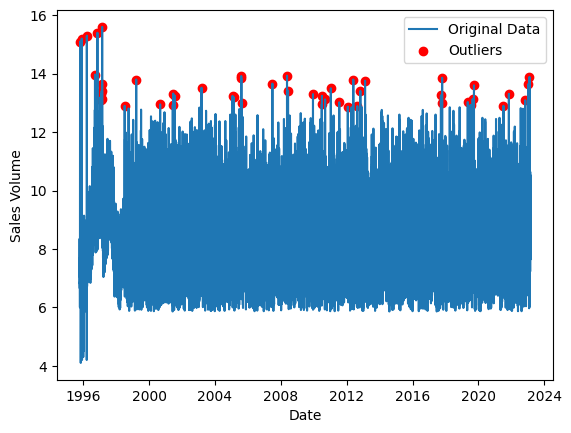

In [26]:
import matplotlib.pyplot as plt

# Plot the original data
plt.plot(data.index, data["Sales_volume"], label = "Original Data")

# Plot the outlier dates and sales volumes
plt.scatter(outlier_dates_sales.index, outlier_dates_sales["Sales_volume"], 
            color = "red", label = "Outliers")

plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.legend()

plt.show()


In [27]:
# Count the number of occurrences of each year in the outlier_dates_sales index
year_counts = outlier_dates_sales.index.year.value_counts()

# Print the year-wise count of outliers
for year, count in year_counts.items():
    print(f"{year} - {count} times")


1997 - 8 times
2005 - 5 times
2019 - 4 times
2012 - 4 times
2010 - 3 times
2017 - 3 times
2001 - 3 times
1996 - 3 times
1995 - 2 times
2021 - 2 times
2011 - 2 times
2008 - 2 times
2023 - 2 times
2009 - 1 times
2007 - 1 times
2003 - 1 times
2013 - 1 times
2000 - 1 times
1999 - 1 times
1998 - 1 times
2022 - 1 times


In [28]:
outlier_dates_sales = outlier_dates_sales.reset_index()
outlier_dates_sales['Year'] = outlier_dates_sales['Date'].dt.year
outlier_count = outlier_dates_sales.groupby('Year')['Sales_volume'].count()

print(outlier_count)

Year
1995    2
1996    3
1997    8
1998    1
1999    1
2000    1
2001    3
2003    1
2005    5
2007    1
2008    2
2009    1
2010    3
2011    2
2012    4
2013    1
2017    3
2019    4
2021    2
2022    1
2023    2
Name: Sales_volume, dtype: int64


In [29]:
# Count the number of missing values per year in the Sales_volume column
missing_values_per_year = data["Sales_volume"].groupby(data.index.year).apply(lambda x: x.isna().sum())

# Print the result
print(missing_values_per_year)


Date
1995    0
1996    0
1997    0
1998    4
1999    2
2000    1
2001    1
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
2021    0
2022    0
2023    0
Name: Sales_volume, dtype: int64


In [30]:
# Select rows where the 'Sales volume in Tonnes' column has a missing value
missing_sales = data[data['Sales_volume'].isna()]['Sales_volume']
print(missing_sales)

Date
1998-04-13   NaN
1998-06-20   NaN
1998-09-09   NaN
1998-12-26   NaN
1999-06-23   NaN
1999-12-12   NaN
2000-06-25   NaN
2001-03-06   NaN
Name: Sales_volume, dtype: float64


In [31]:
results = []
for col in numeric_features:
    result = {
        'Feature': col,
        'Mean': data[col].mean(),
        'Median': data[col].median(),
        'Mode': data[col].mode().tolist(),
        'Range': data[col].max() - data[col].min(),
        'Variance': data[col].var(),
        'Standard Deviation': data[col].std(),
        'Skewness': data[col].skew(),
        'Kurtosis': data[col].kurtosis()
    }
    results.append(result)

EDA = pd.DataFrame(results)
display(EDA)

Feature           Mean     Median  \
0             Sales  541320.140112  536157.00   
1      Sales_volume       8.546244       8.43   
2          Price/Kg      62.958179      63.00   
3          Diameter      16.974995      16.00   
4            Length      17.930300      18.00   
5     Current_stock    8991.488900    9080.00   
6          Re_order     999.154800     999.00   
7         Lead_time       8.011000       8.00   
8   Production_time       4.035200       4.00   
9    Units_Produced   10921.567000   10886.50   
10  Production_cost   20079.277400   20150.50   

                                          Mode     Range      Variance  \
0                                   [433560.0]  713072.0  5.658555e+09   
1                                 [7.92, 8.35]      11.5  2.344348e+00   
2                                       [62.0]      24.0  4.189879e+01   
3                                       [10.0]      24.0  4.182272e+01   
4                                          [7]      28.0  6.599724e+01   
5                          [3276, 5909, 10610]   11986.0  1.170082e+07   
6                       [798, 913, 1181, 1247]     998.0  8.177183e+04   
7                                          [8]      14.0  1.640212e+01   
8                                          [6]       6.0  3.181679e+00   
9                                      [10189]    9783.0  5.236541e+06   
10  [17479, 20862, 23534, 23555, 23627, 24896]    9996.0  8.145651e+06   

    Standard Deviation  Skewness  Kurtosis  
0         75223.368004  0.086901  0.547886  
1             1.531126  0.468308 -0.086608  
2             6.472928 -0.159762 -1.006872  
3             6.467049  0.589913 -0.605864  
4             8.123869  0.015827 -1.201782  
5          3420.646321 -0.015762 -1.184977  
6           285.957747  0.005727 -1.173889  
7             4.049953  0.002804 -1.159690  
8             1.783726 -0.037894 -1.091210  
9          2288.349041  0.031534 -1.180364  
10         2854.058653 -0.042865 -1.173977

In [32]:
# Calculate Skewness and Kurtosis

Skewness = data.skew()
Kurtosis = data.kurtosis()

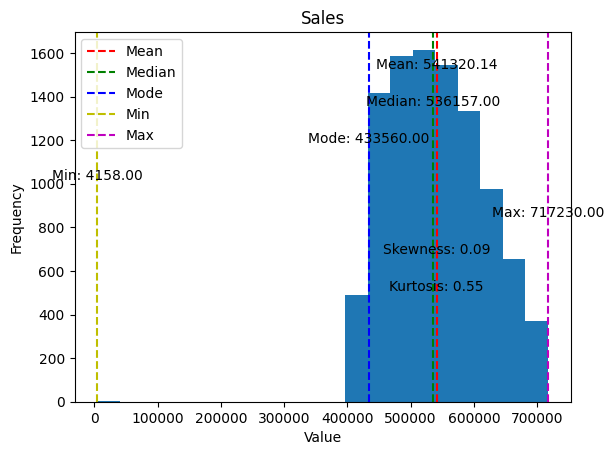

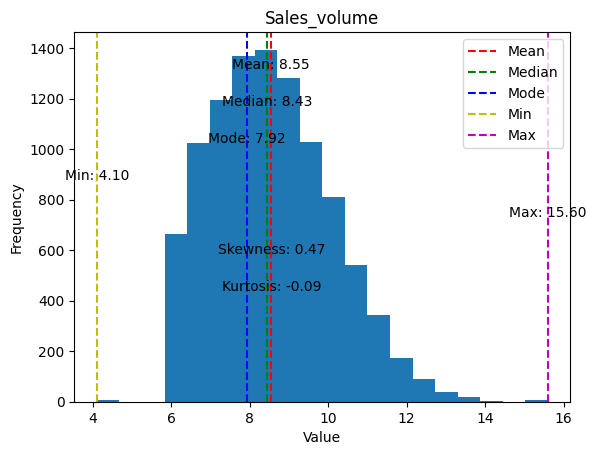

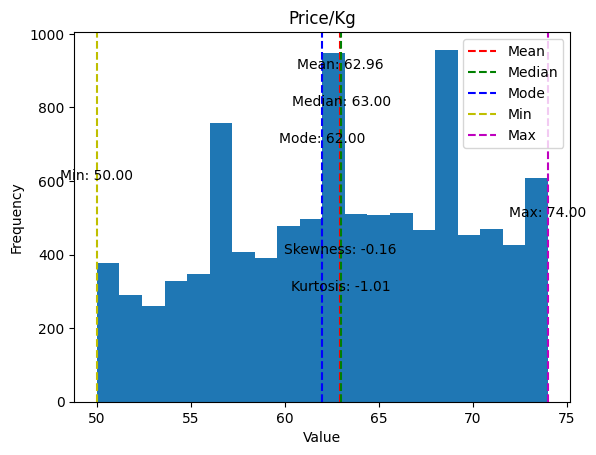

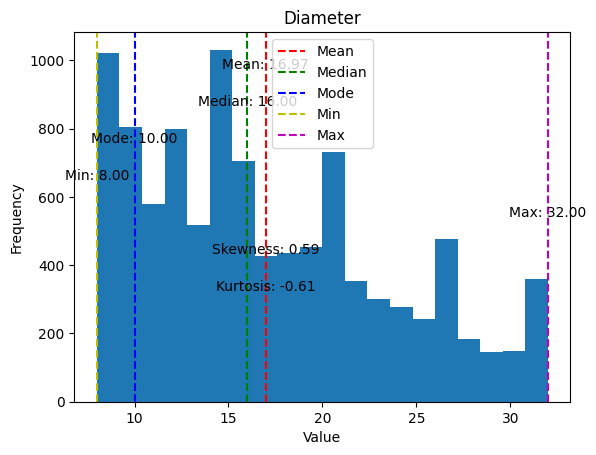

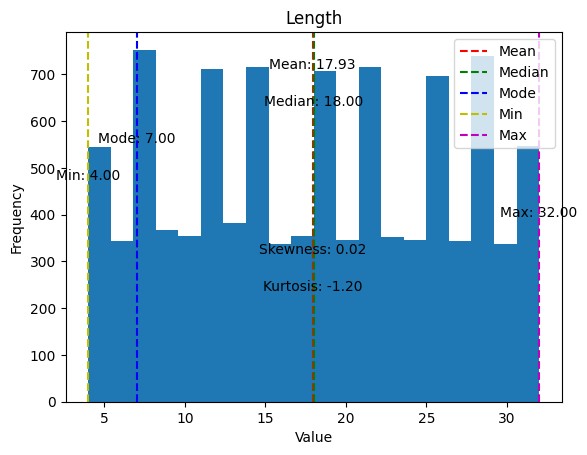

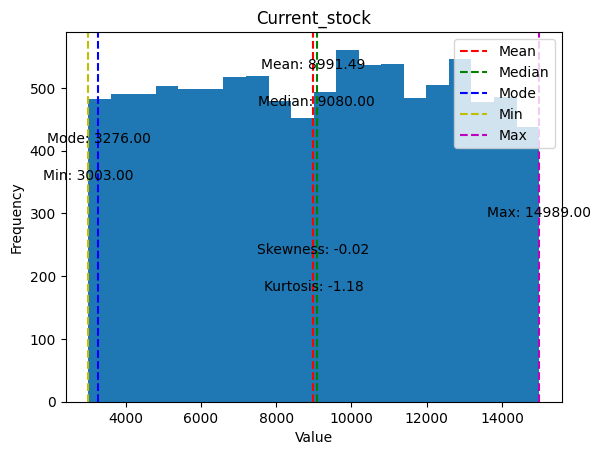

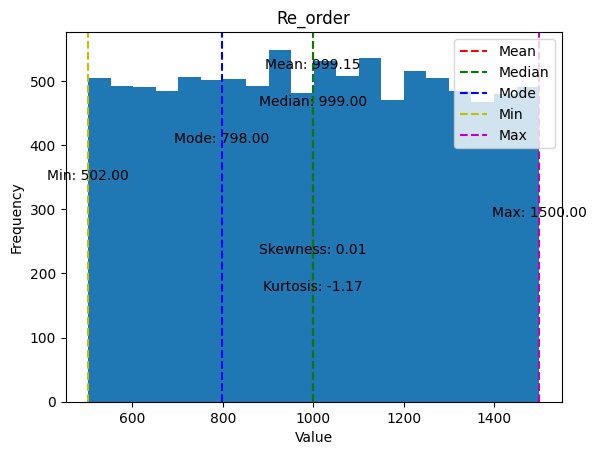

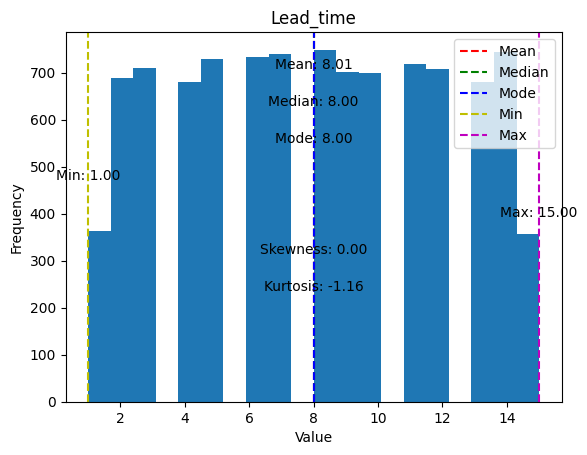

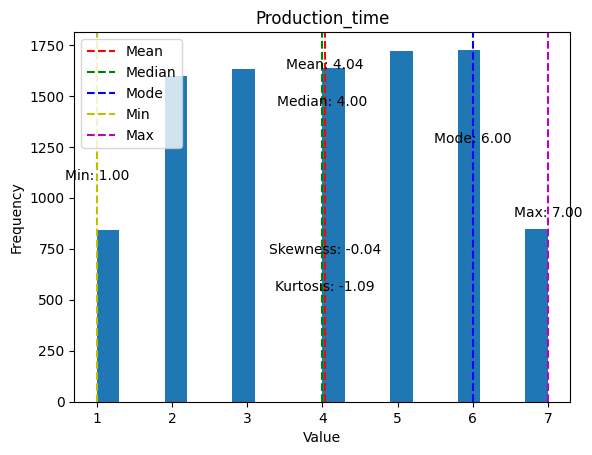

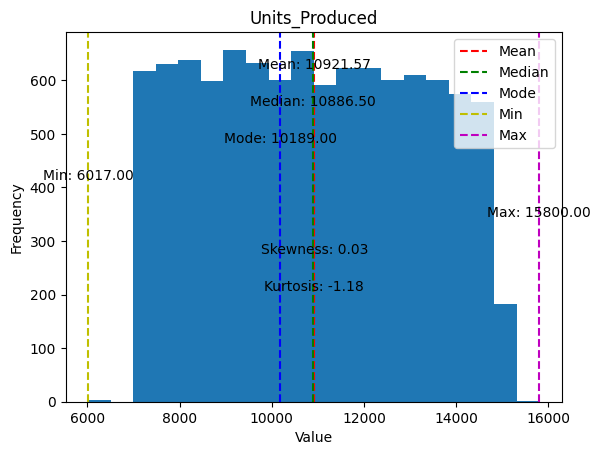

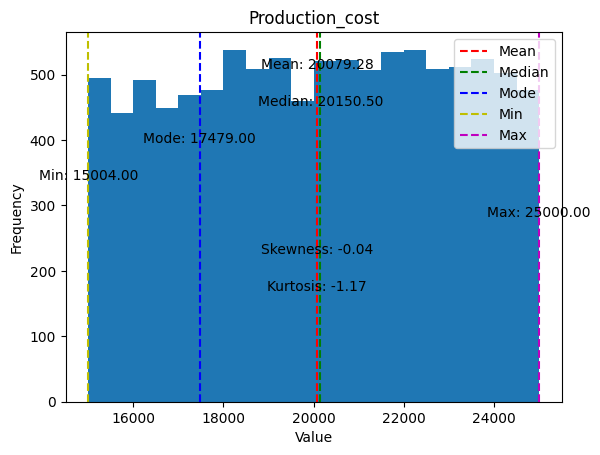

In [33]:
# Plot histograms and add labels

for column in numeric_features:
    fig, ax = plt.subplots()
    ax.hist(data[column], bins = 20)
    ax.axvline(data[column].mean(), color='r', linestyle='--', label='Mean')
    ax.axvline(data[column].median(), color='g', linestyle='--', label='Median')
    ax.axvline(data[column].mode()[0], color='b', linestyle='--', label='Mode')
    ax.axvline(data[column].min(), color='y', linestyle='--', label='Min')
    ax.axvline(data[column].max(), color='m', linestyle='--', label='Max')
    ax.legend()
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Adding Mean, Median, Min, Max, Skewness, and Kurtosis values to the plot
    ax.text(data[column].mean(), ax.get_ylim()[1]*0.9, f'Mean: {data[column].mean():.2f}', ha='center', fontsize=10)
    ax.text(data[column].median(), ax.get_ylim()[1]*0.8, f'Median: {data[column].median():.2f}', ha='center', fontsize=10)
    ax.text(data[column].mode()[0], ax.get_ylim()[1]*0.7, f'Mode: {data[column].mode()[0]:.2f}', ha='center', fontsize=10)
    ax.text(data[column].min(), ax.get_ylim()[1]*0.6, f'Min: {data[column].min():.2f}', ha='center', fontsize=10)
    ax.text(data[column].max(), ax.get_ylim()[1]*0.5, f'Max: {data[column].max():.2f}', ha='center', fontsize=10)
    ax.text(data[column].mean(), ax.get_ylim()[1]*0.4, f'Skewness: {Skewness[column]:.2f}', ha='center', fontsize=10)
    ax.text(data[column].mean(), ax.get_ylim()[1]*0.3, f'Kurtosis: {Kurtosis[column]:.2f}', ha='center', fontsize=10)
    
plt.show()

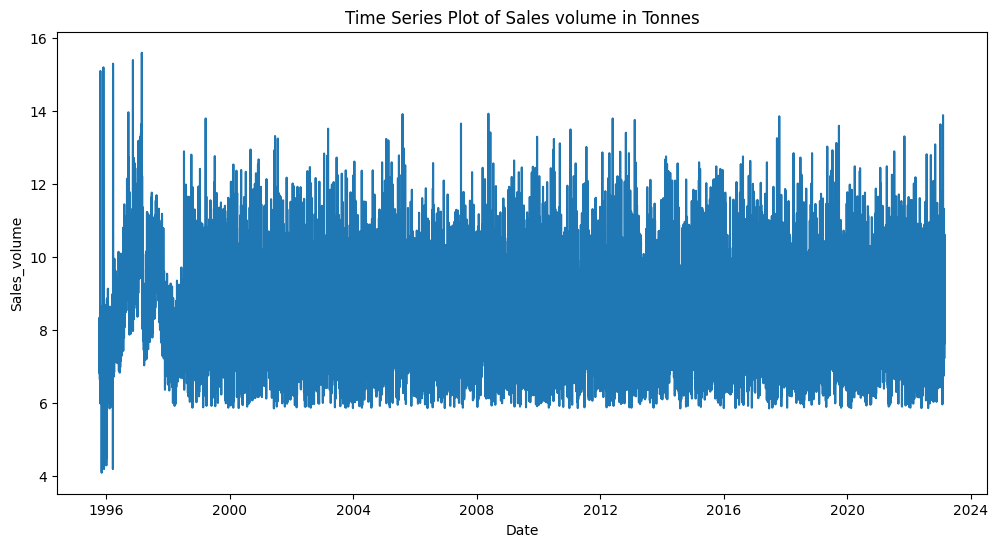

In [34]:
# plotting time series plot for "Sales volume in Tonnes" 
plt.figure(figsize = (12, 6))
plt.plot(data.index, data["Sales_volume"])
plt.xlabel("Date")
plt.ylabel("Sales_volume")
plt.title("Time Series Plot of Sales volume in Tonnes")
plt.show()

<AxesSubplot: >

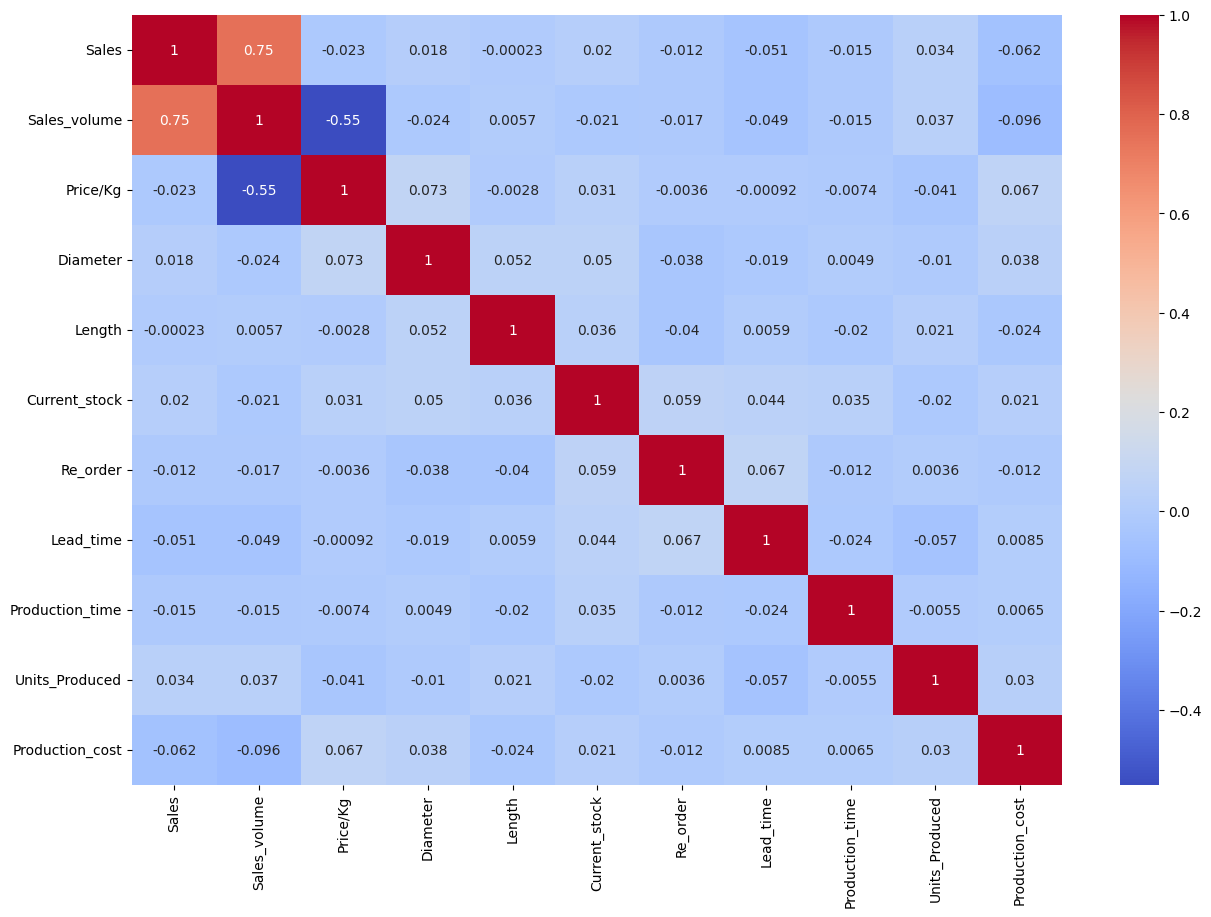

In [35]:
# Creating a heatmap
plt.figure(figsize = (15,10))
sns.heatmap(data.corr(), annot = True, cmap = 'coolwarm')

# Auto - EDA tools - SweetViz

                                             |                                             | [  0%]   00:00 ->…


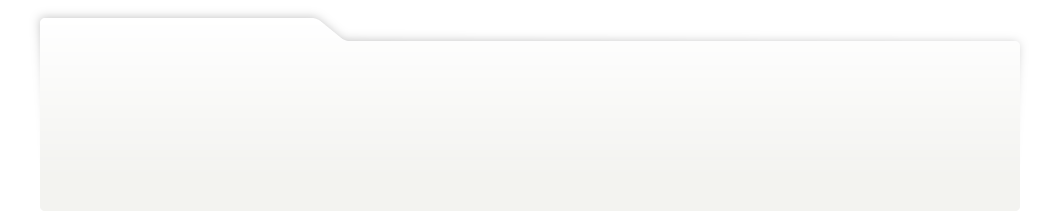
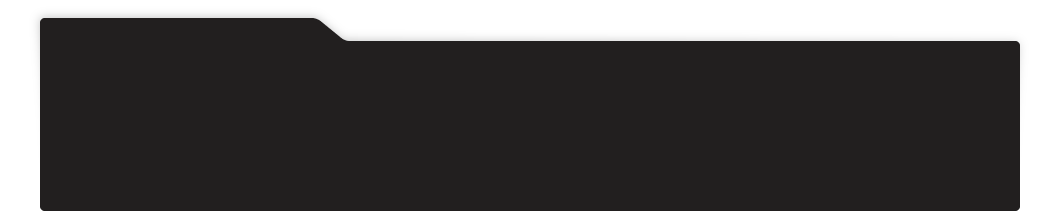
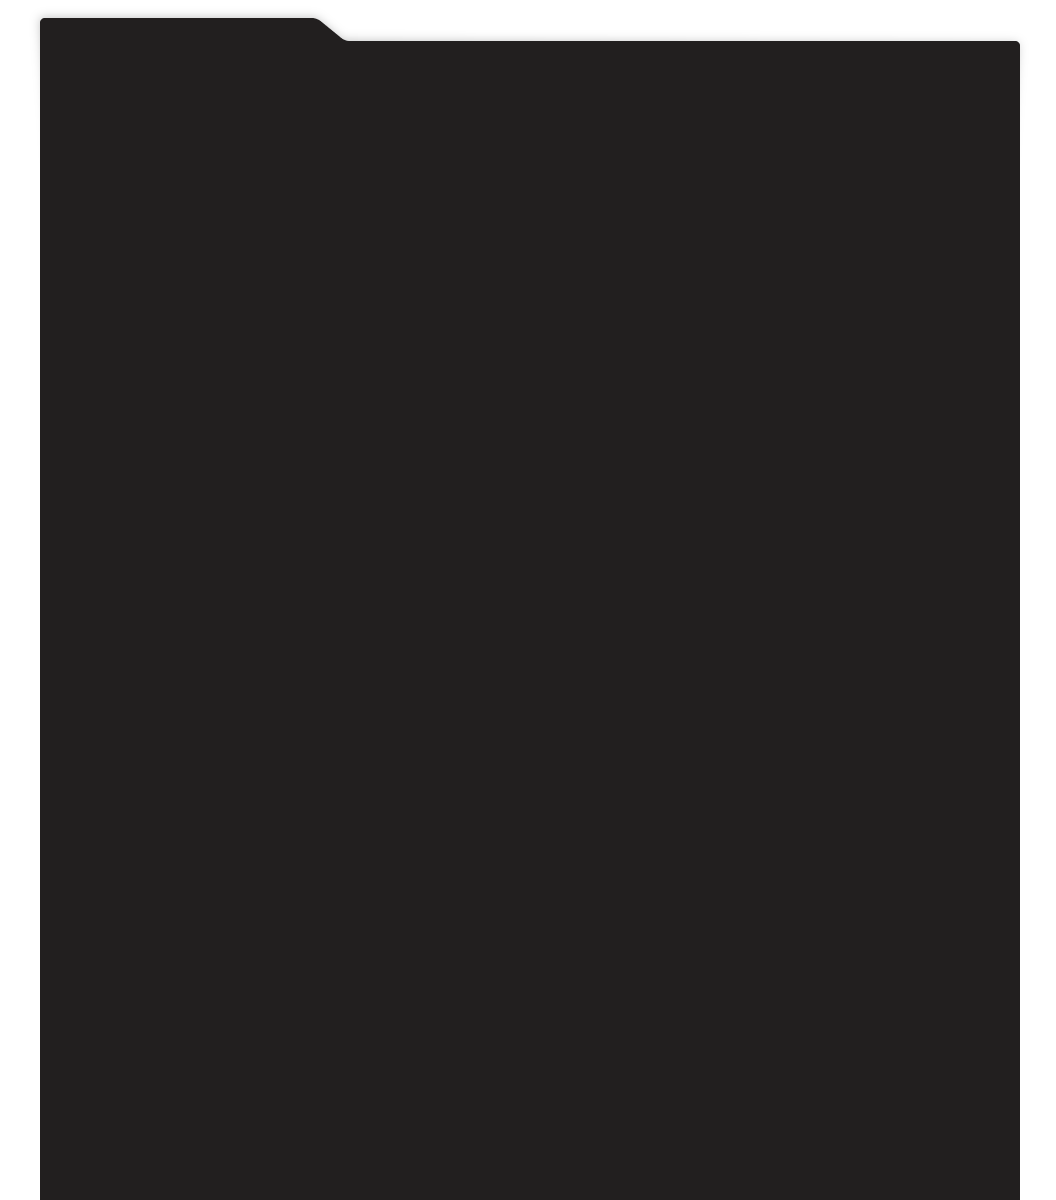
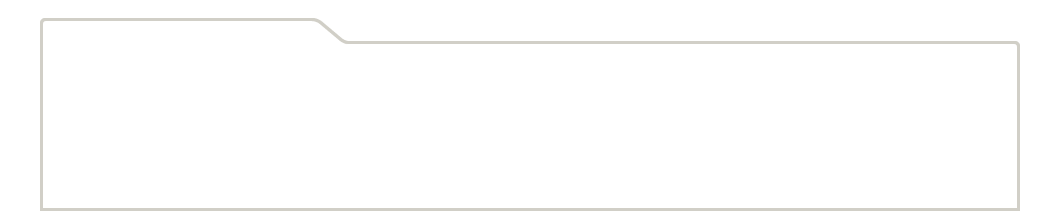
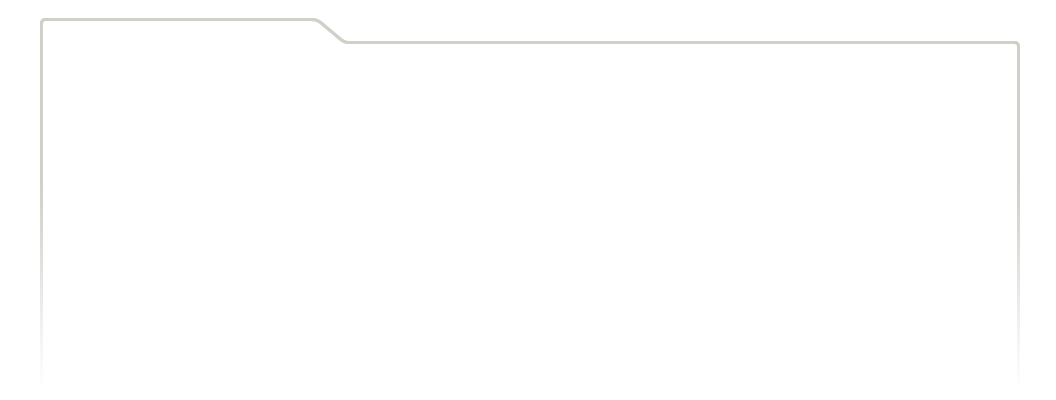
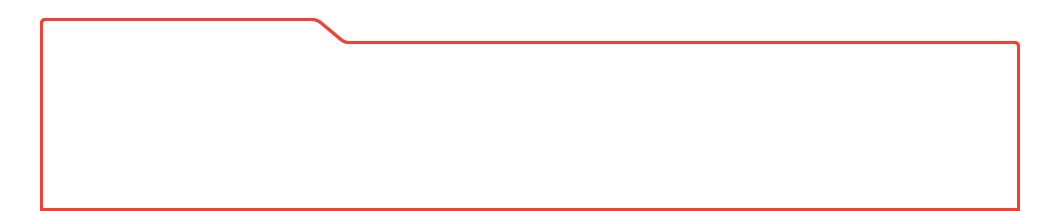
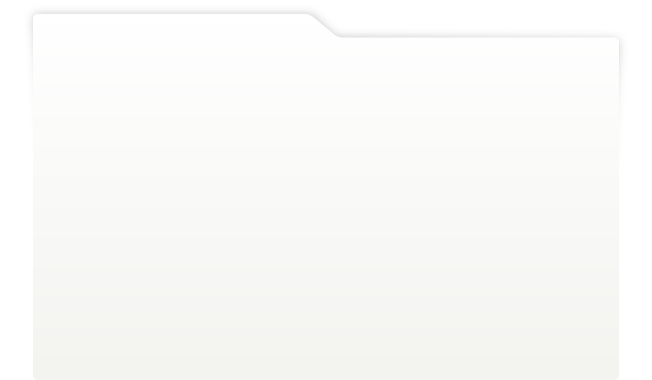
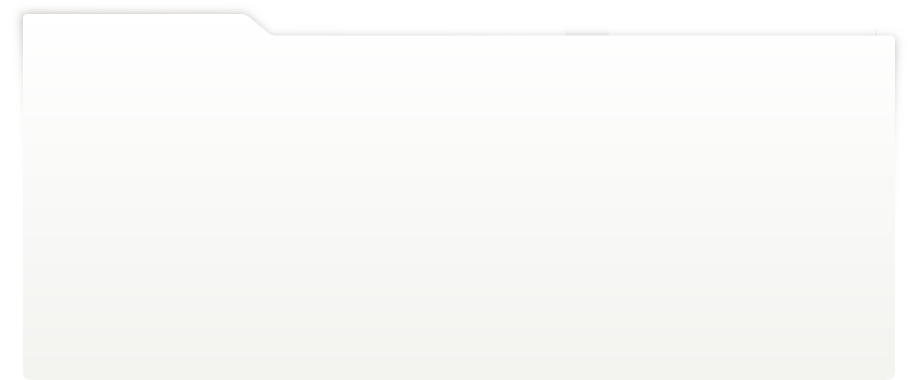
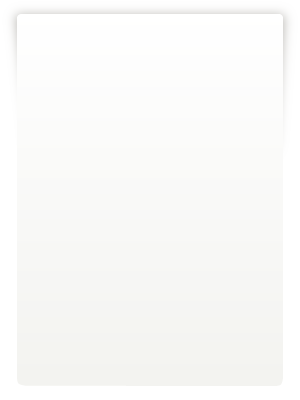
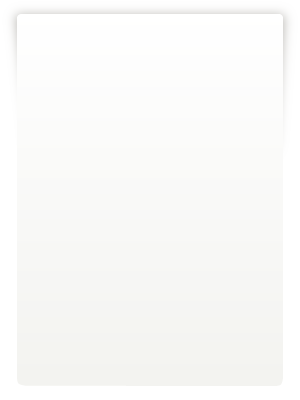
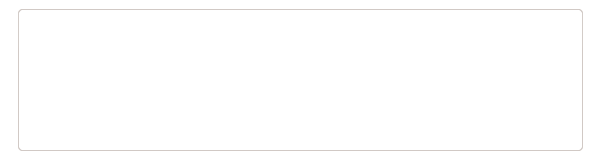
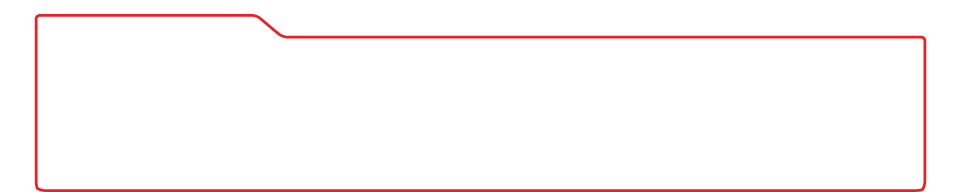
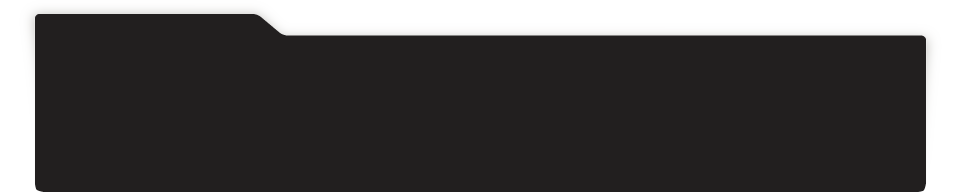
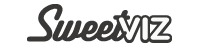
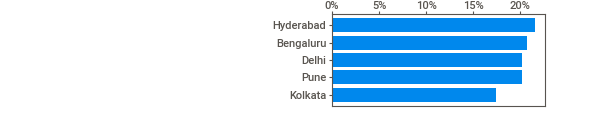
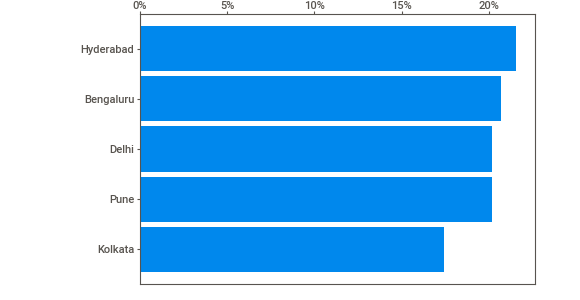
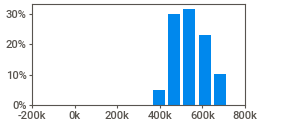
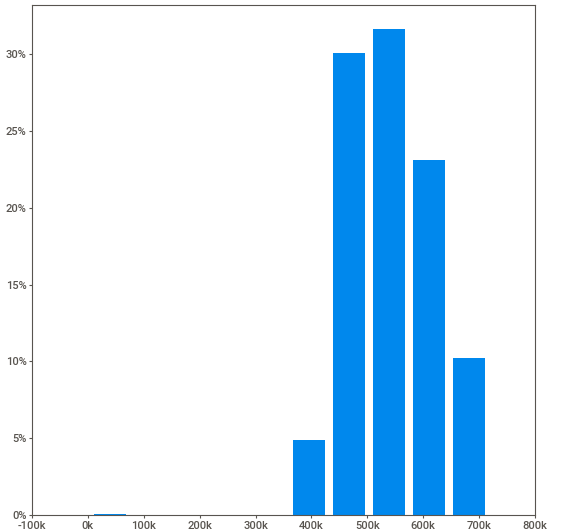
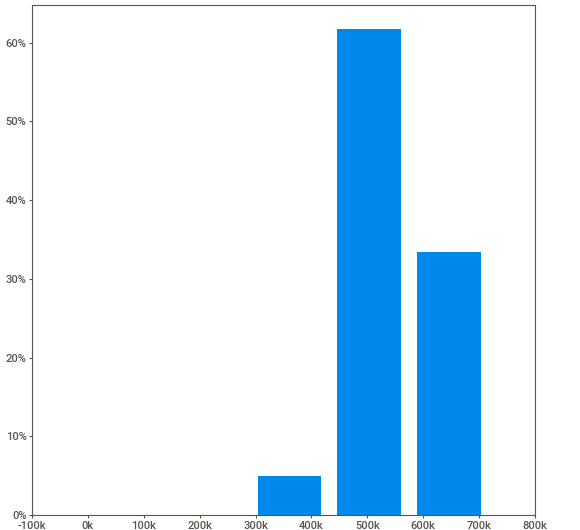
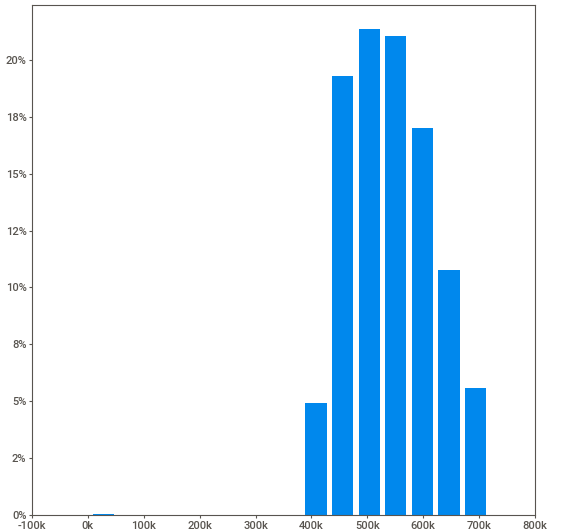
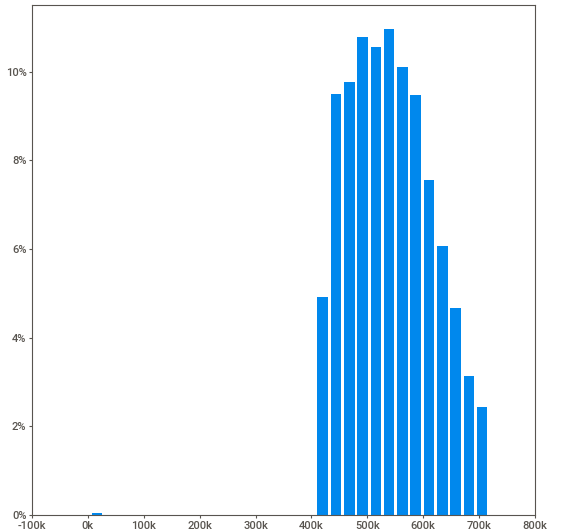
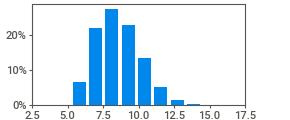
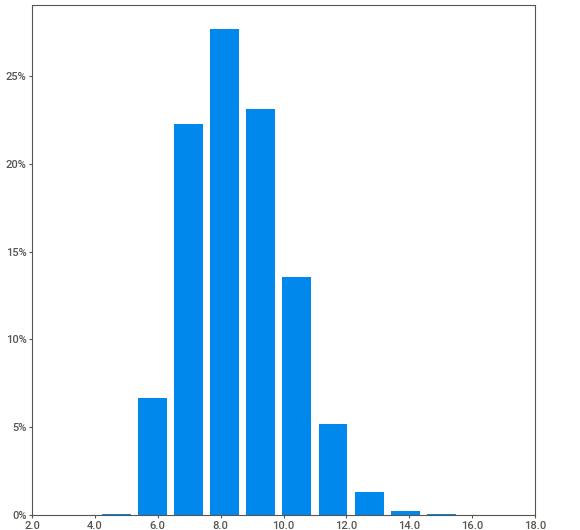
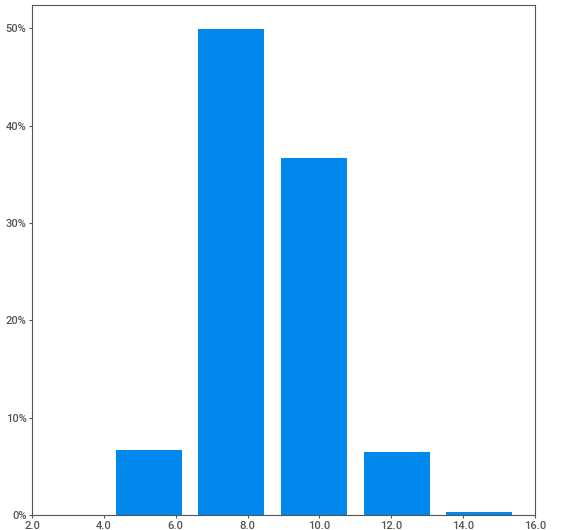
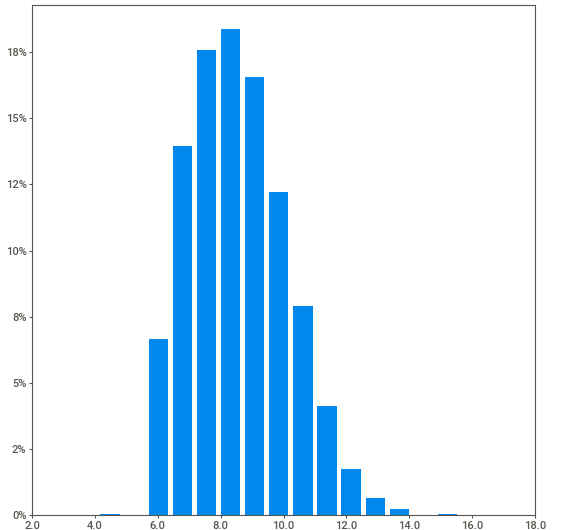
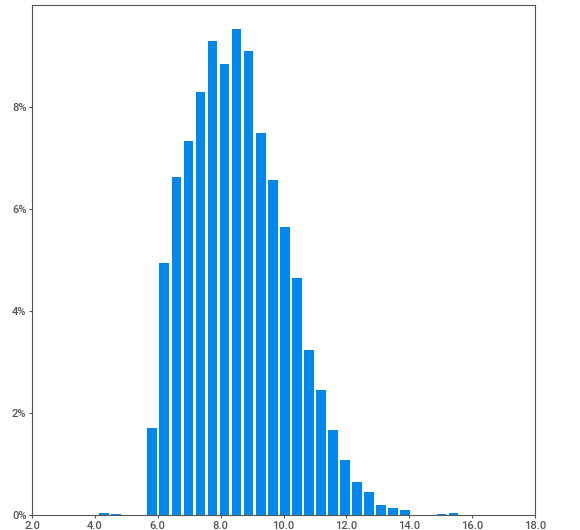
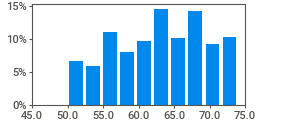
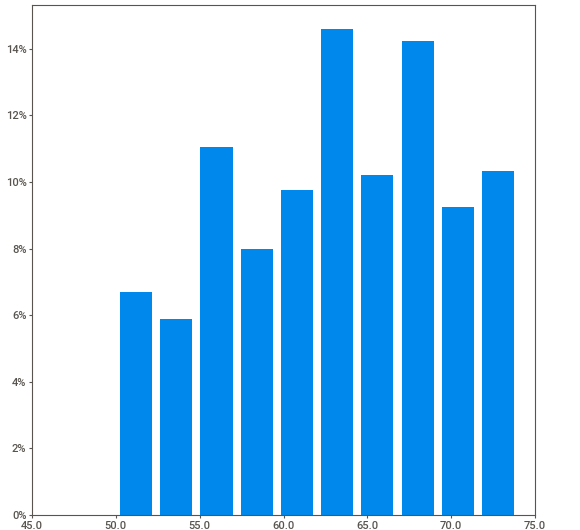
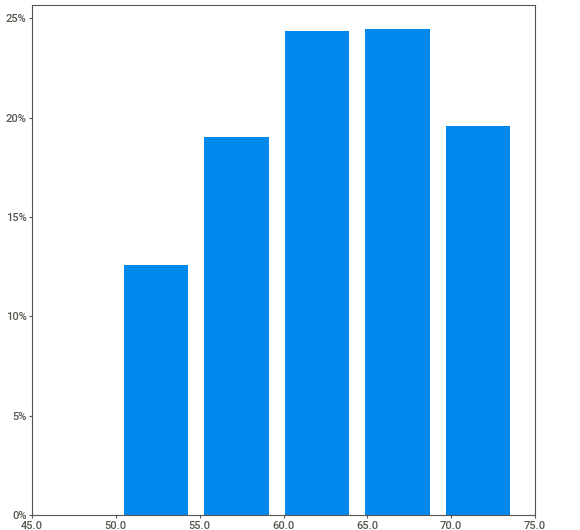
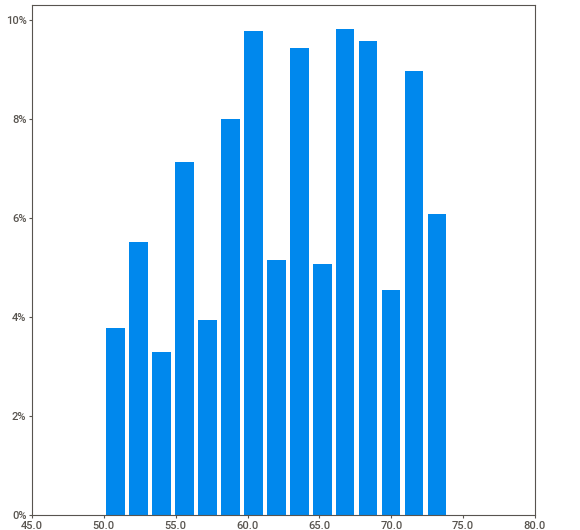
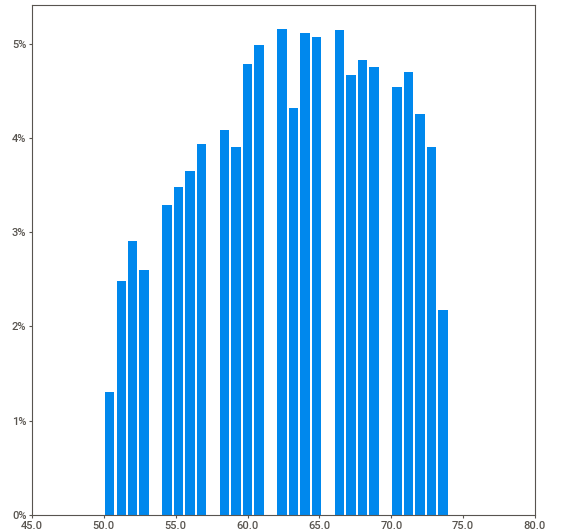
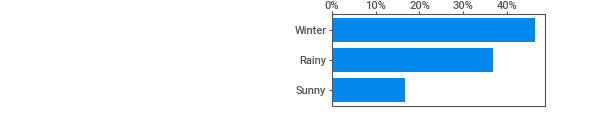
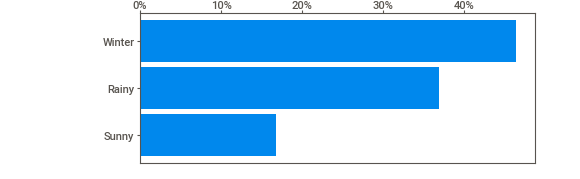
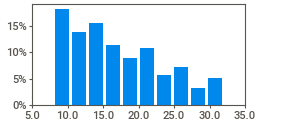
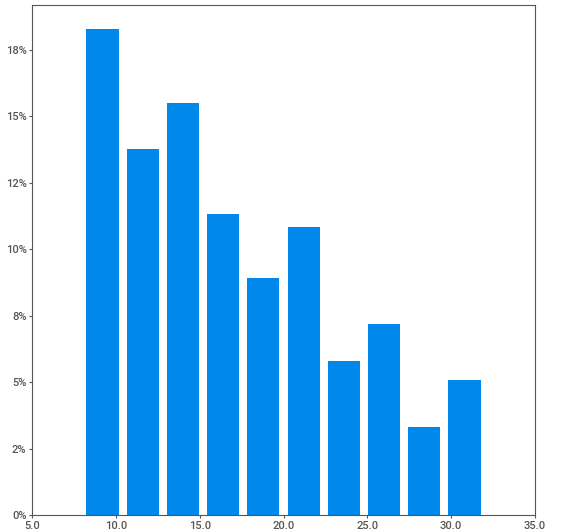
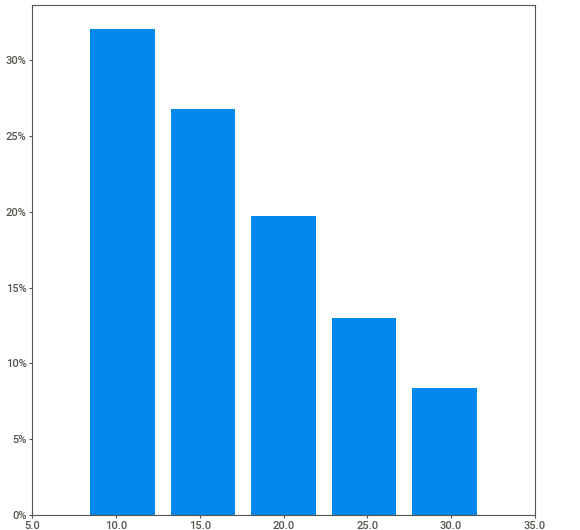
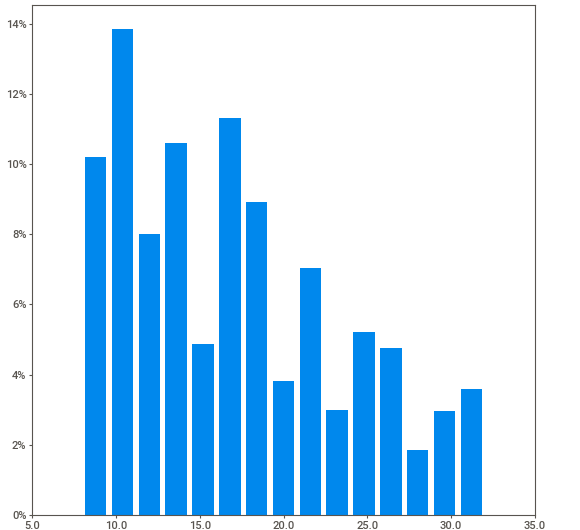
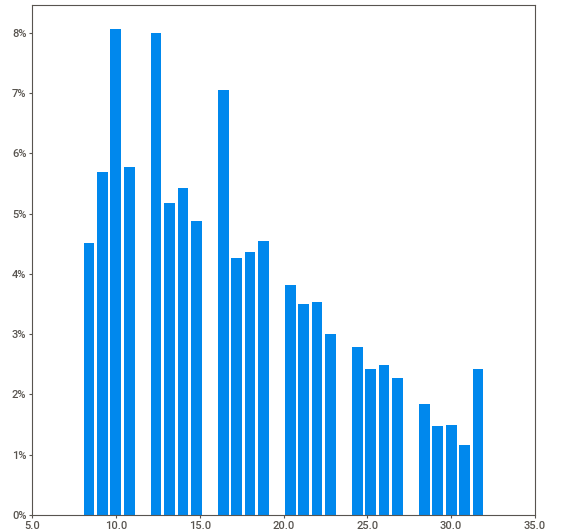
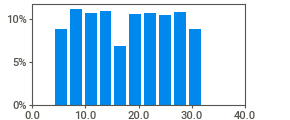
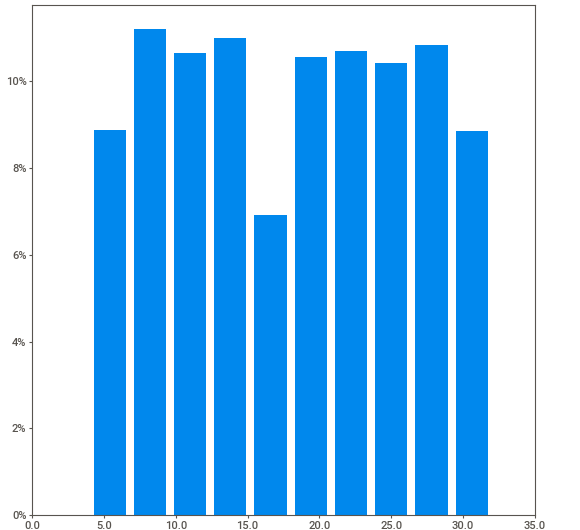
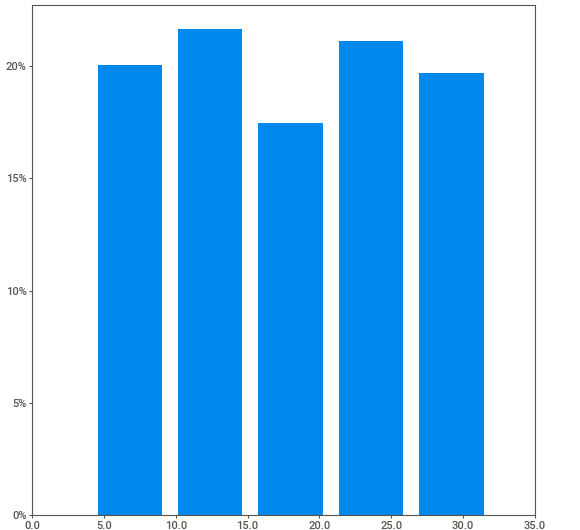
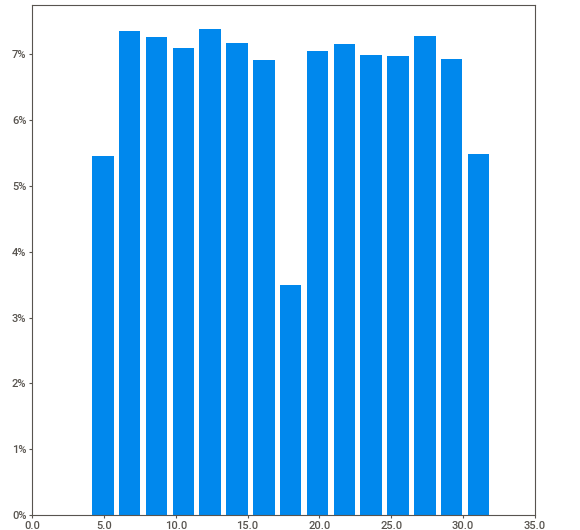
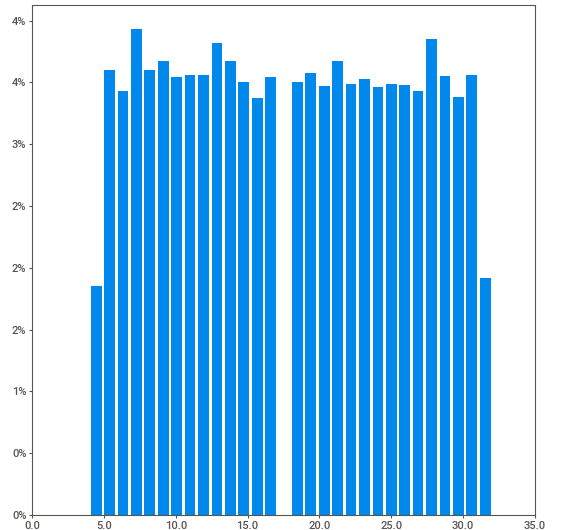
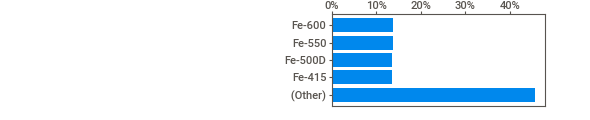
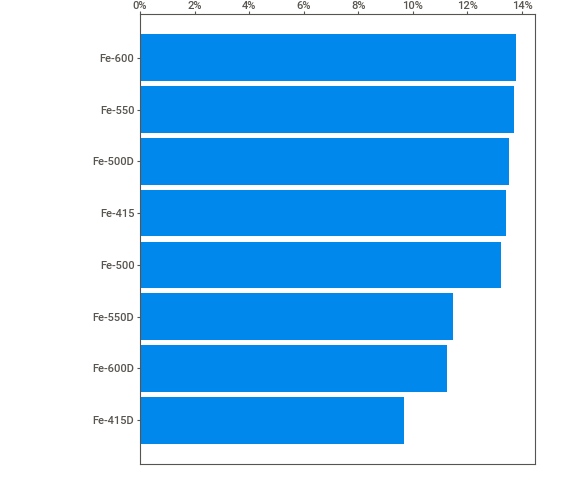
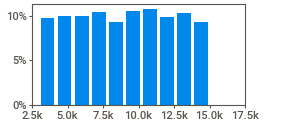
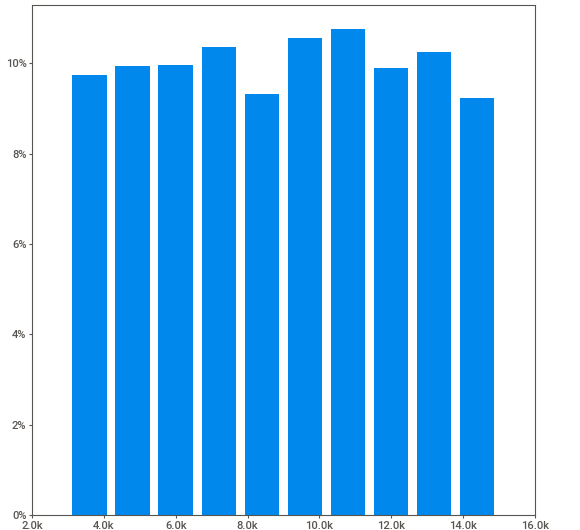
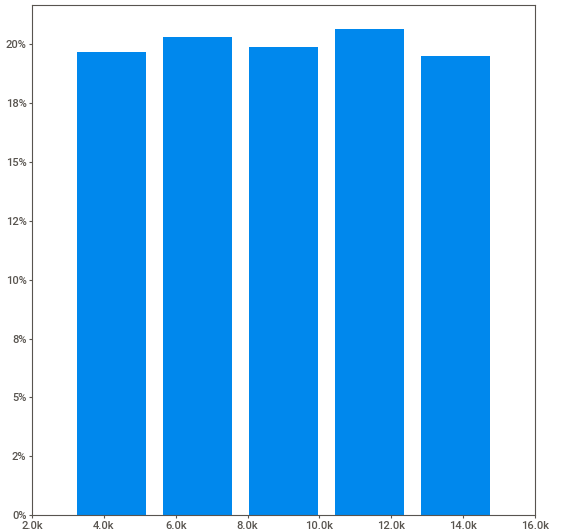
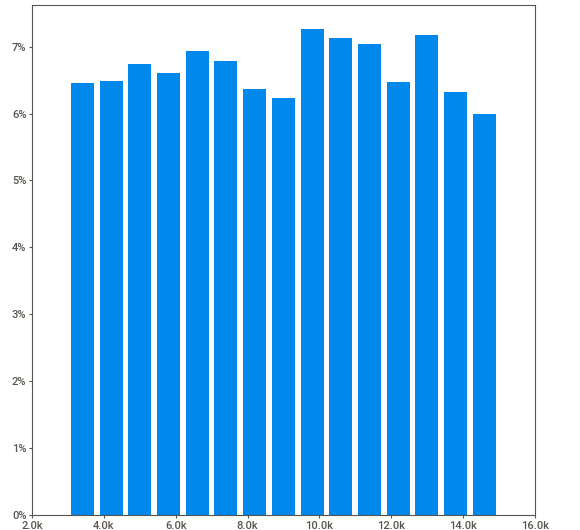
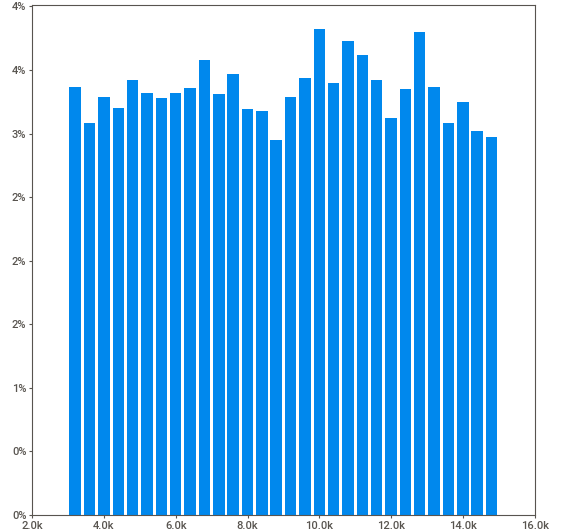
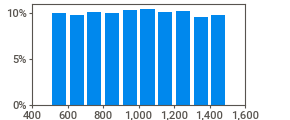
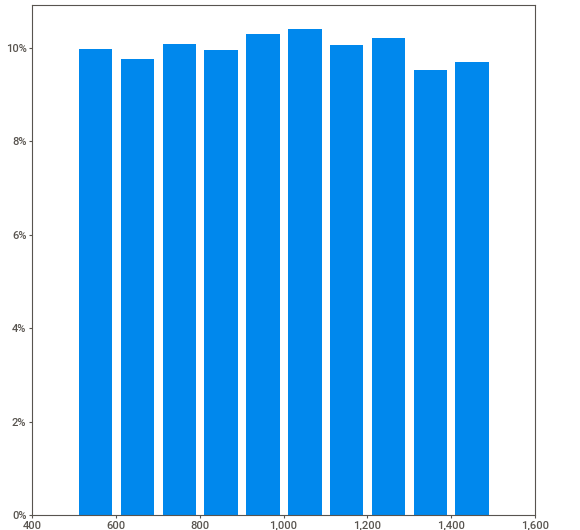
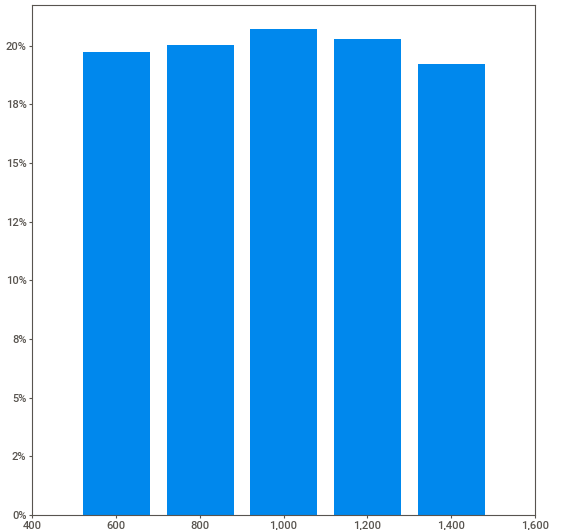
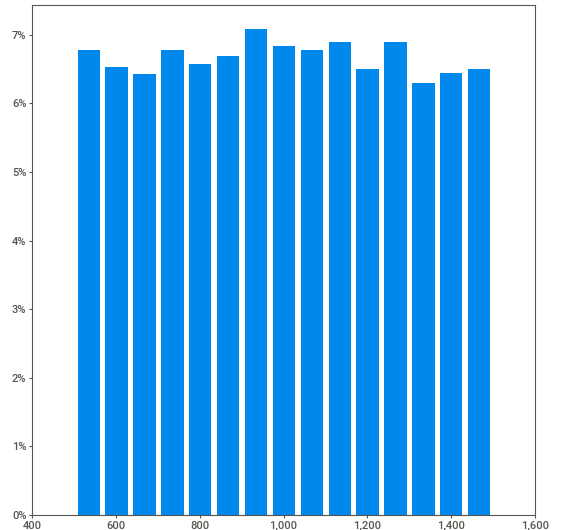
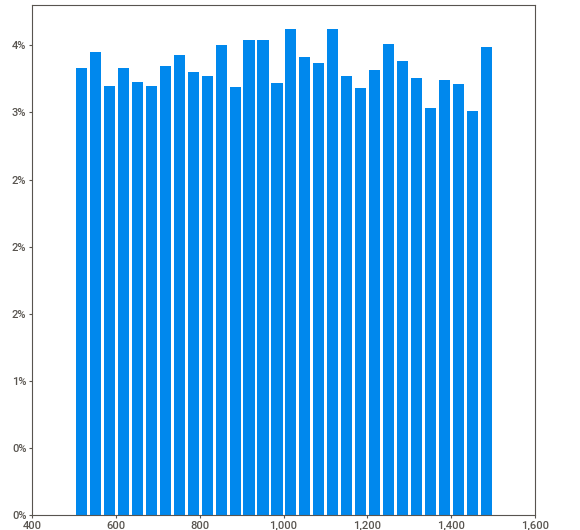
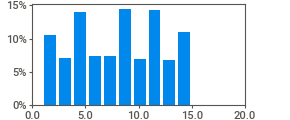
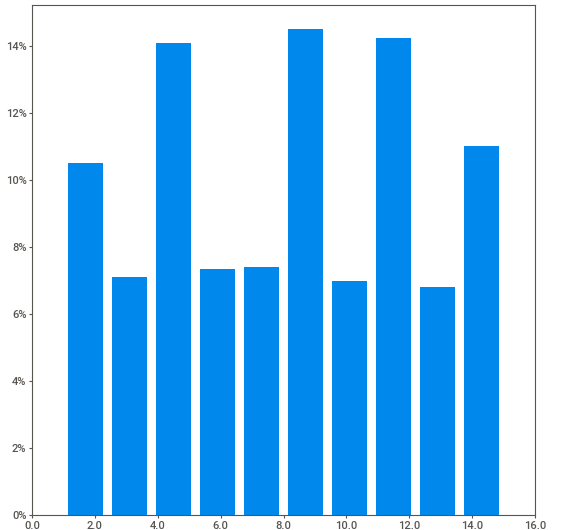
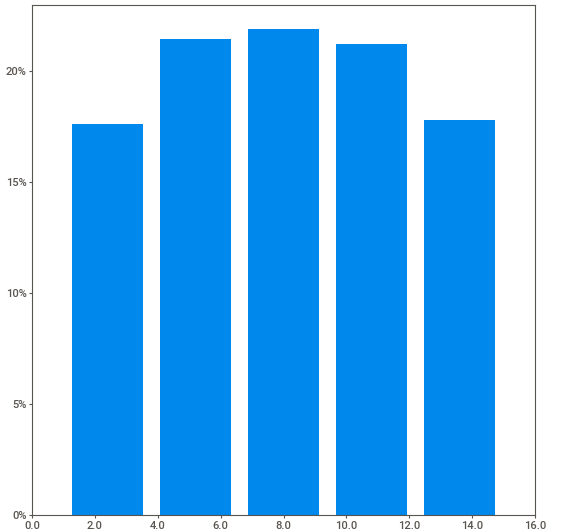
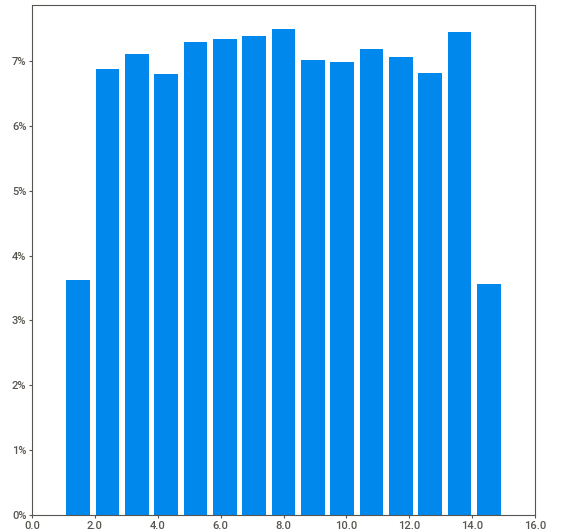
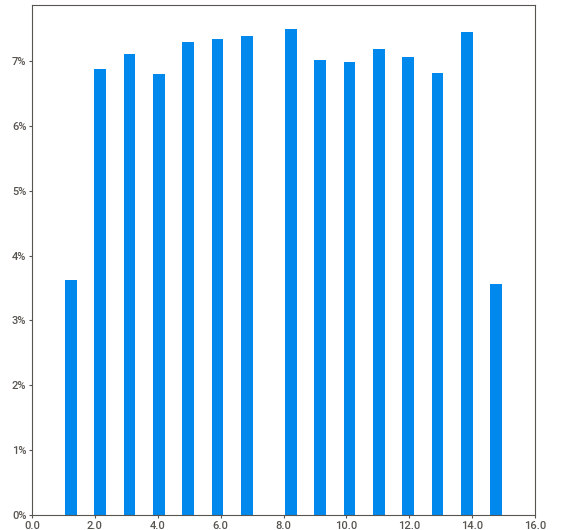
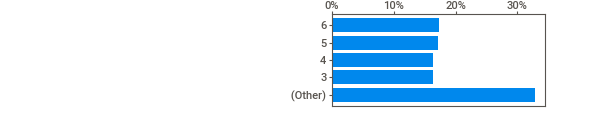
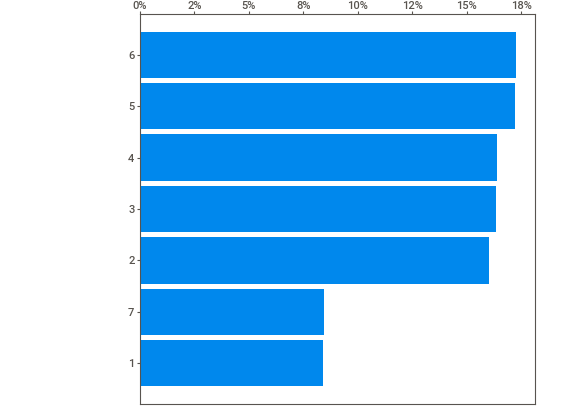
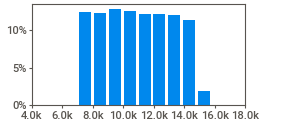
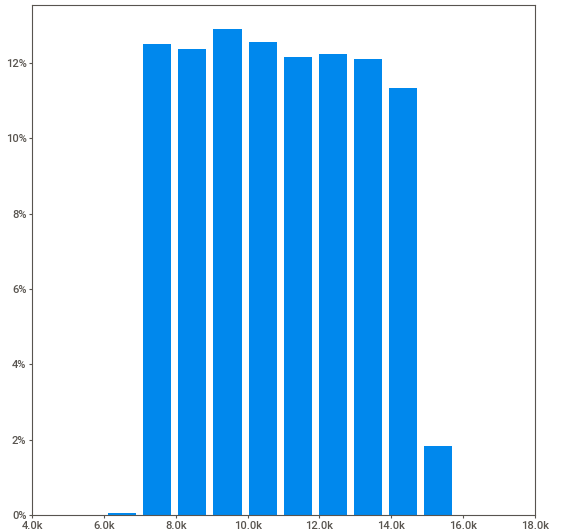
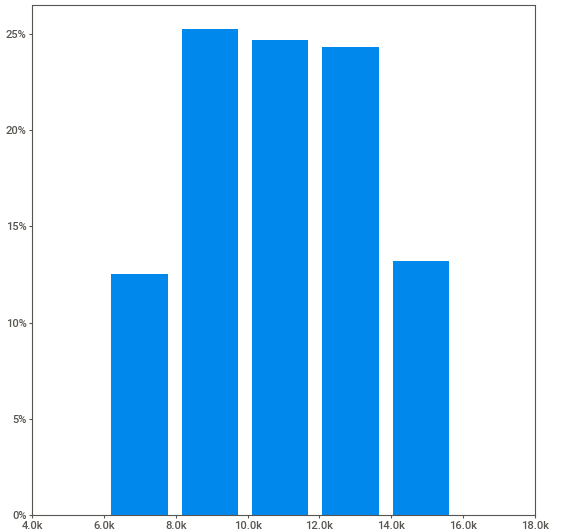
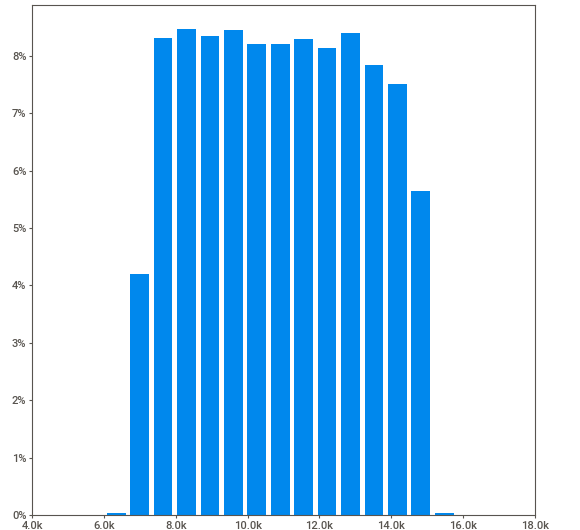
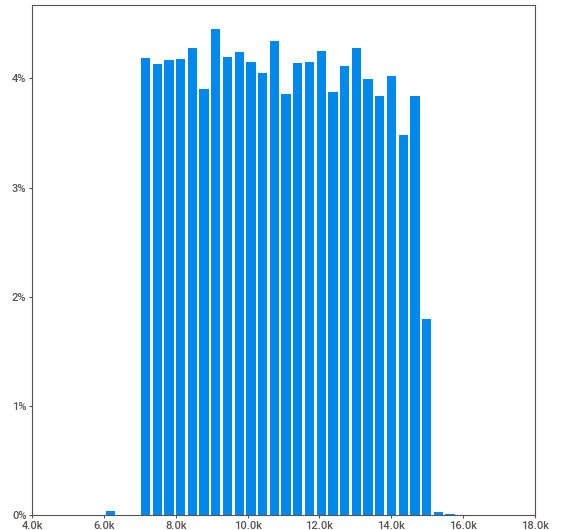
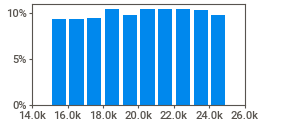
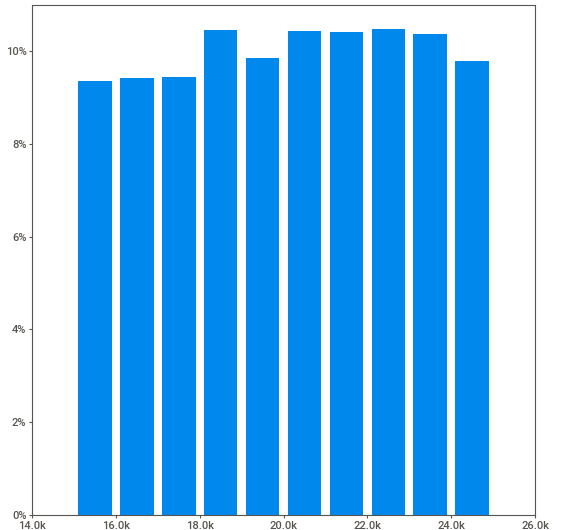
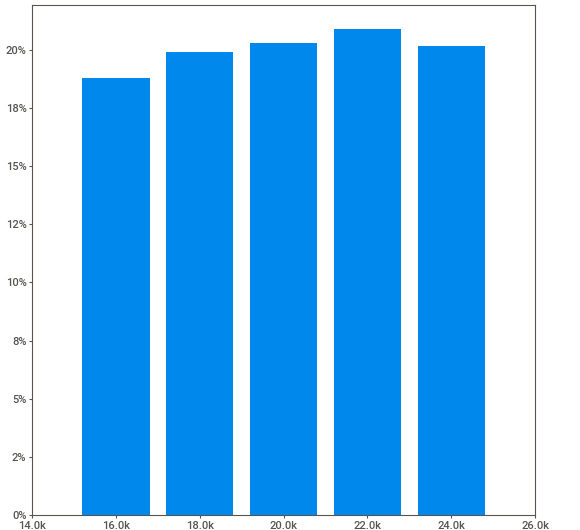
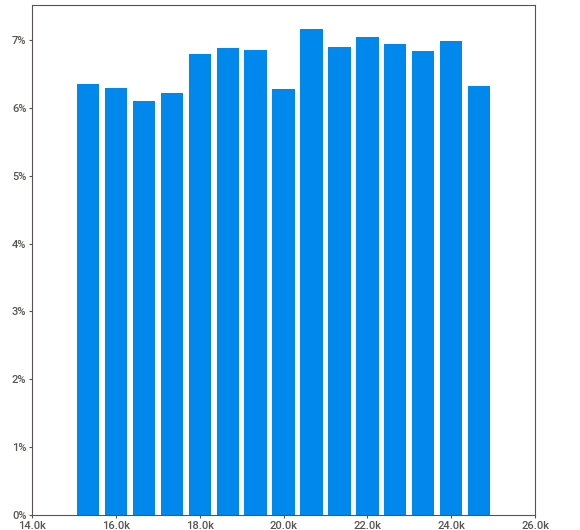
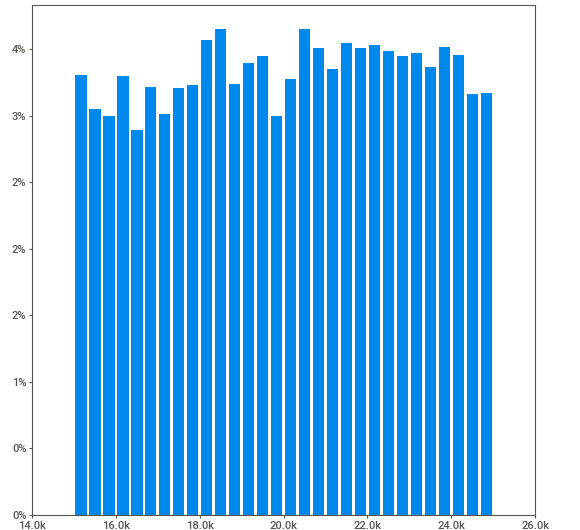
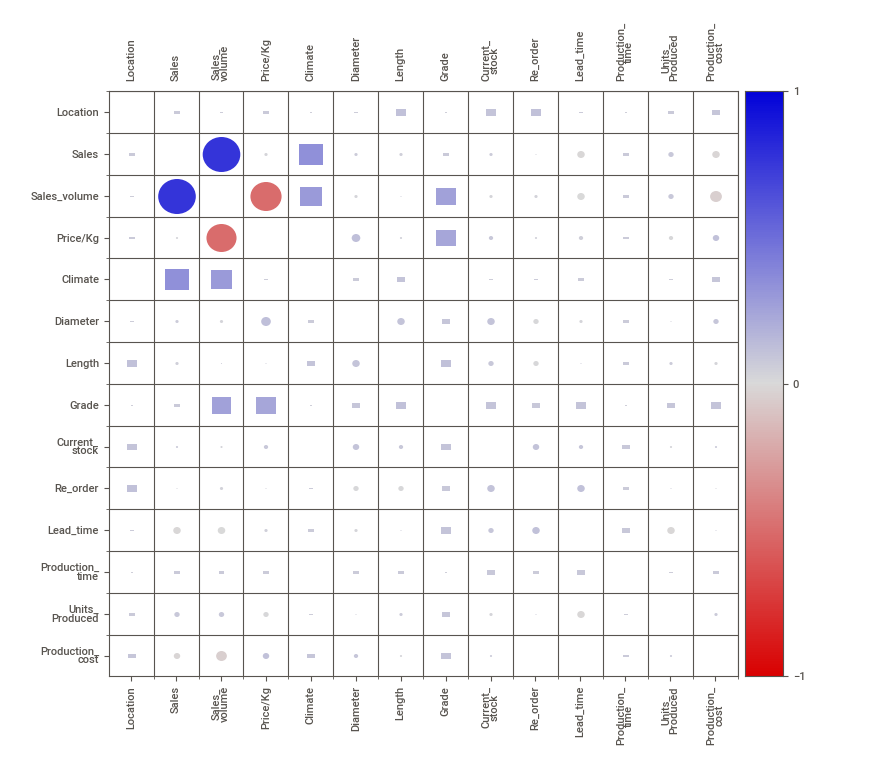
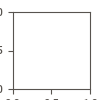

In [36]:
## Auto-EDA
import sweetviz as sv
s = sv.analyze(data)
s.show_notebook()

# Data Preprocessing

In [37]:
# Select rows where the 'Sales volume in Tonnes' column has a missing value
missing_sales = data[data['Sales_volume'].isna()]['Sales_volume']
print(missing_sales)

Date
1998-04-13   NaN
1998-06-20   NaN
1998-09-09   NaN
1998-12-26   NaN
1999-06-23   NaN
1999-12-12   NaN
2000-06-25   NaN
2001-03-06   NaN
Name: Sales_volume, dtype: float64


In [38]:
missing_sales.isna().sum()

8

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

In [40]:
# Separate Sales and Sales_volume from other columns
numeric_features1 = ['Sales', 'Sales_volume']
numeric_features1

['Sales', 'Sales_volume']

In [41]:
# Separate Sales and Sales_volume from other columns
numeric_features2 = ['Price/Kg', 'Diameter', 'Length',
       'Current_stock', 'Re_order', 'Lead_time', 'Production_time',
       'Units_Produced', 'Production_cost']
numeric_features2

['Price/Kg',
 'Diameter',
 'Length',
 'Current_stock',
 'Re_order',
 'Lead_time',
 'Production_time',
 'Units_Produced',
 'Production_cost']

In [42]:
categorical_features = ['Location', 'Climate', 'Grade']
categorical_features

['Location', 'Climate', 'Grade']

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [44]:
from sklearn.base import TransformerMixin, BaseEstimator

class ForwardFillImputer(TransformerMixin, BaseEstimator):
    def __init__(self, features):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.features] = X[self.features].fillna(method = 'ffill')
        return X

In [45]:
# Create pipelines for numeric and categorical columns
numeric_pipeline1 = Pipeline(steps = [('imputer', ForwardFillImputer(numeric_features1))])
numeric_pipeline2 = Pipeline(steps = [('imputer', ForwardFillImputer(numeric_features2))])
categorical_pipeline = Pipeline(steps = [('imputer', ForwardFillImputer(categorical_features))])

In [46]:
from sklearn.compose import ColumnTransformer

# Use ColumnTransformer to apply pipelines to specific columns
preprocessor = ColumnTransformer(transformers=[('num1', numeric_pipeline1, numeric_features1),
                                               ('num2', numeric_pipeline2, numeric_features2),
                                               ('cat', categorical_pipeline, categorical_features)])
# Preprocess Sales and Sales_volume data
imputation_data = preprocessor.fit_transform(data)

In [47]:
# Save preprocessor using joblib
import joblib
joblib.dump(preprocessor, 'Impute.joblib')

['Impute.joblib']

In [48]:
column_names = numeric_features1 + numeric_features2 + categorical_features
imputation_data_df = pd.DataFrame(imputation_data, columns=column_names)
print(imputation_data_df.head())

      Sales Sales_volume Price/Kg Diameter Length Current_stock Re_order  \
0  424440.0         7.07     60.0     32.0   13.0       10770.0    618.0   
1  426000.0         8.35     51.0     12.0    7.0        8039.0   1195.0   
2  429360.0         6.82     63.0     12.0    9.0        7328.0   1372.0   
3  432000.0         6.86     63.0      8.0   25.0        3040.0    688.0   
4  432000.0         7.45     58.0     32.0   27.0        9011.0    704.0   

  Lead_time Production_time Units_Produced Production_cost   Location Climate  \
0       7.0             3.0        14828.0         18734.0       Pune   Rainy   
1       2.0             3.0        12795.0         21294.0  Hyderabad   Rainy   
2      14.0             6.0        13576.0         19759.0    Kolkata   Rainy   
3      14.0             2.0         8060.0         23073.0  Bengaluru   Rainy   
4      11.0             6.0         7532.0         19986.0      Delhi   Rainy   

     Grade  
0   Fe-500  
1   Fe-415  
2  Fe-500D  
3   

In [49]:
imputation_data.shape

(10000, 14)

In [50]:
# Convert imputation_data array to DataFrame with column names
imputation_data = pd.DataFrame(imputation_data, columns = column_names)

In [51]:
imputation_data.index = data.index

In [52]:
imputation_data["Sales_volume"].head()

Date
1995-10-14    7.07
1995-10-15    8.35
1995-10-16    6.82
1995-10-17    6.86
1995-10-18    7.45
Name: Sales_volume, dtype: object

In [53]:
imputation_data.reset_index(inplace = True)
imputation_data.rename(columns = {"index": "Date"}, inplace = True)
imputation_data.head()

Date     Sales Sales_volume Price/Kg Diameter Length Current_stock  \
0 1995-10-14  424440.0         7.07     60.0     32.0   13.0       10770.0   
1 1995-10-15  426000.0         8.35     51.0     12.0    7.0        8039.0   
2 1995-10-16  429360.0         6.82     63.0     12.0    9.0        7328.0   
3 1995-10-17  432000.0         6.86     63.0      8.0   25.0        3040.0   
4 1995-10-18  432000.0         7.45     58.0     32.0   27.0        9011.0   

  Re_order Lead_time Production_time Units_Produced Production_cost  \
0    618.0       7.0             3.0        14828.0         18734.0   
1   1195.0       2.0             3.0        12795.0         21294.0   
2   1372.0      14.0             6.0        13576.0         19759.0   
3    688.0      14.0             2.0         8060.0         23073.0   
4    704.0      11.0             6.0         7532.0         19986.0   

    Location Climate    Grade  
0       Pune   Rainy   Fe-500  
1  Hyderabad   Rainy   Fe-415  
2    Kolkata   Rainy  Fe-500D  
3  Bengaluru   Rainy   Fe-550  
4      Delhi   Rainy   Fe-500

In [54]:
imputation_data.to_csv("clean_data.csv")

In [55]:
# Create a new variable with "Date" and "Sales_volume" columns
sales_volume_data = imputation_data.loc[:, ["Date", "Sales_volume"]].copy()
sales_volume_data.head()

Date Sales_volume
0 1995-10-14         7.07
1 1995-10-15         8.35
2 1995-10-16         6.82
3 1995-10-17         6.86
4 1995-10-18         7.45

In [56]:
# Make a copy of the remaining columns
remaining_data = imputation_data.copy()
remaining_data.drop(columns=["Date", "Sales_volume"], inplace=True)
remaining_data.isna().sum()

Sales              0
Price/Kg           0
Diameter           0
Length             0
Current_stock      0
Re_order           0
Lead_time          0
Production_time    0
Units_Produced     0
Production_cost    0
Location           0
Climate            0
Grade              0
dtype: int64

In [57]:
sales_volume_data.isna().sum()

Date            0
Sales_volume    0
dtype: int64

In [58]:
# Convert "Date" column to datetime format
sales_volume_data["Date"] = pd.to_datetime(sales_volume_data["Date"])

# Set "Date" column as index
sales_volume_data.set_index("Date", inplace=True)


In [59]:
## Converting the Date Column in to Daily based  
clean_data = sales_volume_data.loc['1995-10-14':'2023-02-28'] 
##clean_data = sales_volume_data['Sales_volume'].resample('D').sum()
clean_data

Sales_volume
Date                   
1995-10-14         7.07
1995-10-15         8.35
1995-10-16         6.82
1995-10-17         6.86
1995-10-18         7.45
...                 ...
2023-02-24         9.13
2023-02-25         9.99
2023-02-26         8.84
2023-02-27         7.64
2023-02-28        10.61

[10000 rows x 1 columns]

In [60]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 1995-10-14 to 2023-02-28
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sales_volume  10000 non-null  object
dtypes: object(1)
memory usage: 156.2+ KB


In [61]:
clean_data = pd.DataFrame(clean_data)
clean_data

Sales_volume
Date                   
1995-10-14         7.07
1995-10-15         8.35
1995-10-16         6.82
1995-10-17         6.86
1995-10-18         7.45
...                 ...
2023-02-24         9.13
2023-02-25         9.99
2023-02-26         8.84
2023-02-27         7.64
2023-02-28        10.61

[10000 rows x 1 columns]

# Plotting Level, Trend, and Seasonality

In [62]:
import statsmodels.api as sm

# Perform seasonal decomposition for Additive
decomposition = sm.tsa.seasonal_decompose(clean_data, model ='additive', period = 365)

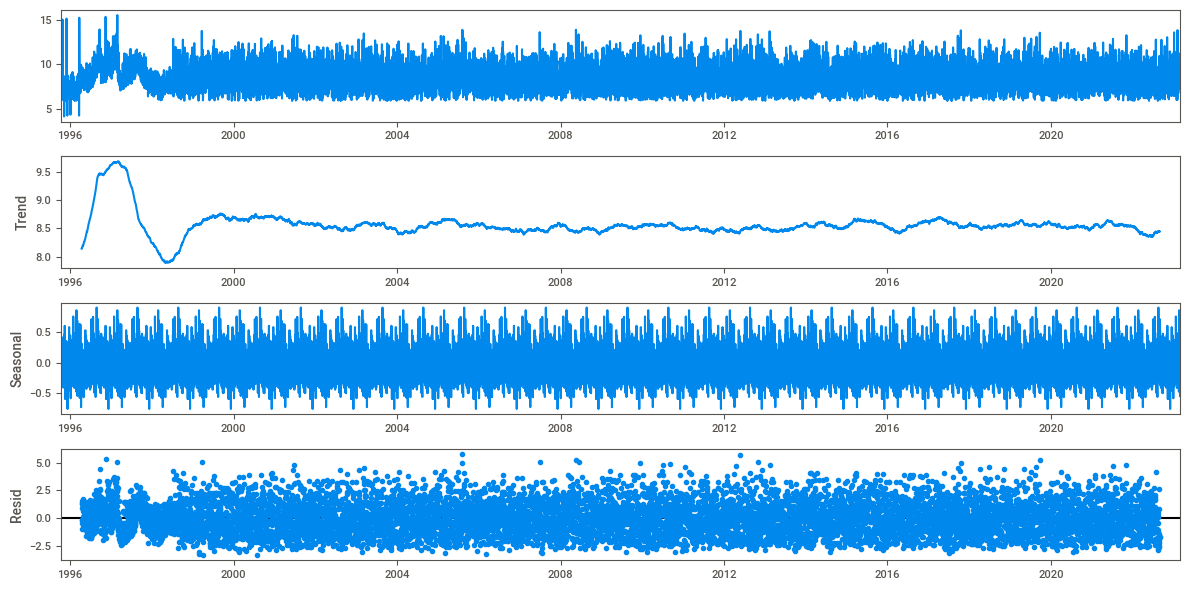

In [63]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

# Plot the decomposition
fig = decomposition.plot()
plt.show()

The p-values for both coefficients are very small (i.e., less than 0.05), indicating that both the intercept and slope terms are statistically significant. Therefore, you can conclude that the trend in your time series is linear, with a negative slope.

# ADF Test

**Performing Augumented-Dickey-Fuller Test to check whether data is stationary or not.**

In [64]:
from statsmodels.tsa.stattools import adfuller

In [65]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against the null hypothesis, fail to reject the null hypothesis. Data has a unit root and is non-stationary")

In [66]:
adf_test(clean_data['Sales_volume'])

ADF Statistics: -10.518718887039098
p- value: 9.809085180114798e-19
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


The ADF statistic is a negative number, in this case -10.518718887039098, and it indicates the strength of the rejection of the null hypothesis. The null hypothesis is that the time series has a unit root, while the alternative hypothesis is that it does not have a unit root.

The p-value is a very small number, in this case 9.809085180114798e-19, which is smaller than the commonly used significance level of 0.05. This means that we have strong evidence against the null hypothesis and can reject it.

Therefore, the data has no unit root and is stationary. This means that the mean and variance of the time series data remain constant over time, making it easier to model and forecast. 

# Lag Plot 

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

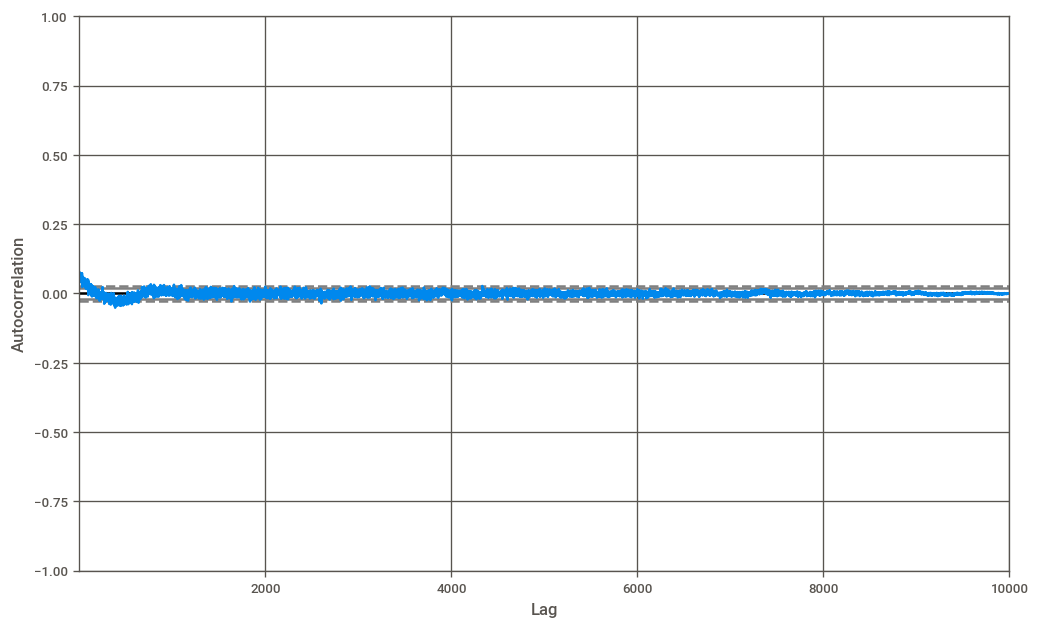

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pandas.plotting import autocorrelation_plot
plt.rcParams.update({'figure.figsize': (10,6), 'figure.dpi':120})
autocorrelation_plot(clean_data['Sales_volume'].astype(float).tolist())

<AxesSubplot: xlabel='Date'>

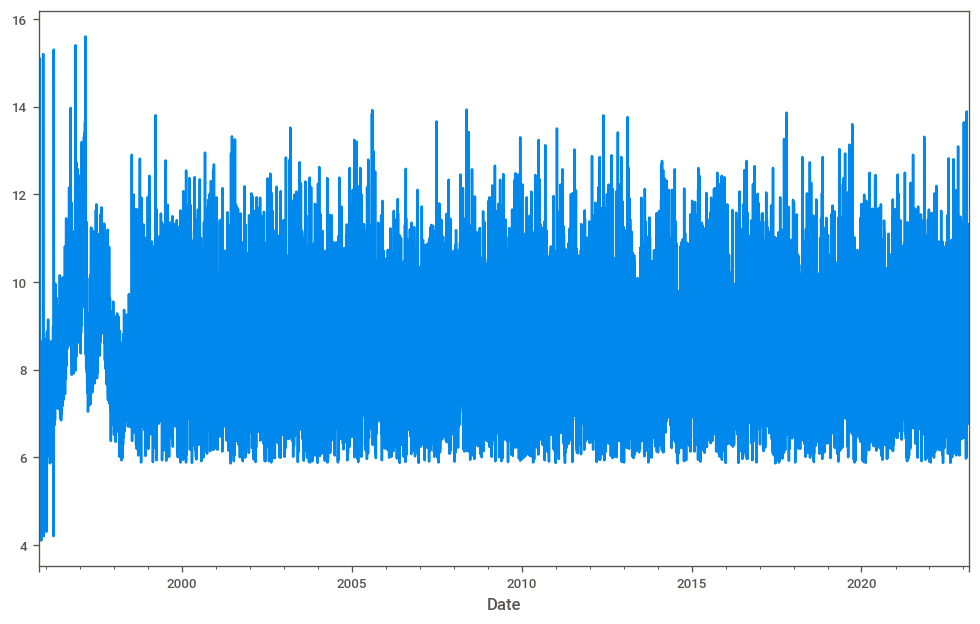

In [68]:
clean_data['Sales_volume'] = pd.to_numeric(clean_data['Sales_volume'])
clean_data['Sales_volume'].plot()


ACF (Auto Correlation Function) and PACF (Partial Auto Correlation Function) plots are useful tools in time series analysis to identify the relationship between the observations in a time series.

**ACF plots** show the correlation between an observation in a time series and the previous observations. The ACF plot shows the correlation coefficient on the y-axis and the number of lags on the x-axis. A significant positive correlation at lag k in the ACF plot indicates that the observation at time t-k can be used to predict the observation at time t.

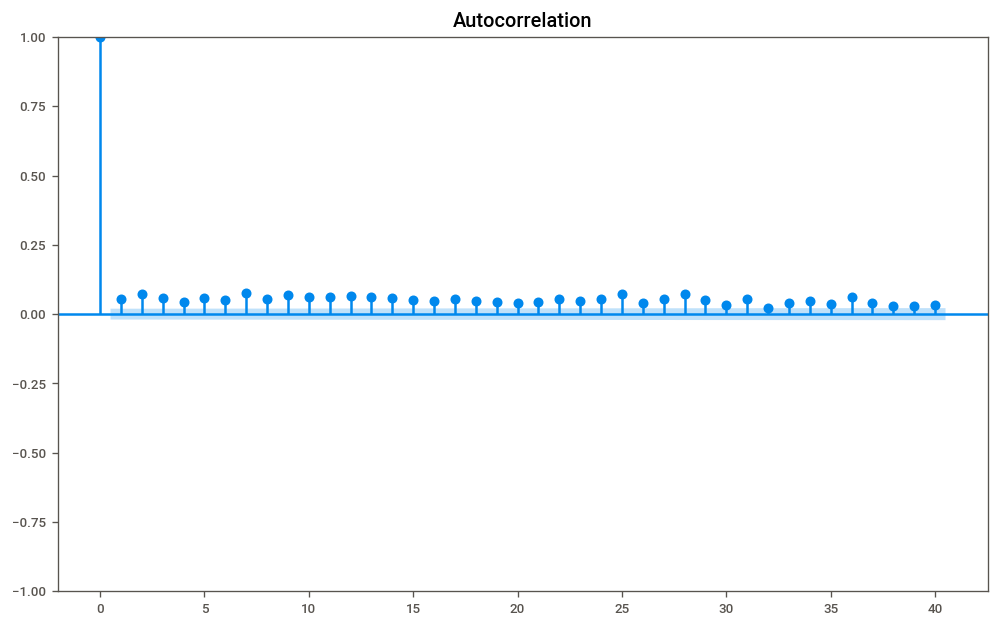

In [69]:
acf = plot_acf(clean_data)

**PACF plots** show the correlation between an observation and its lagged values after accounting for the effect of other lags. The PACF plot shows the correlation coefficient on the y-axis and the number of lags on the x-axis. A significant positive correlation at lag k in the PACF plot indicates that the observation at time t-k can be used to predict the observation at time t after removing the effects of all other lags.

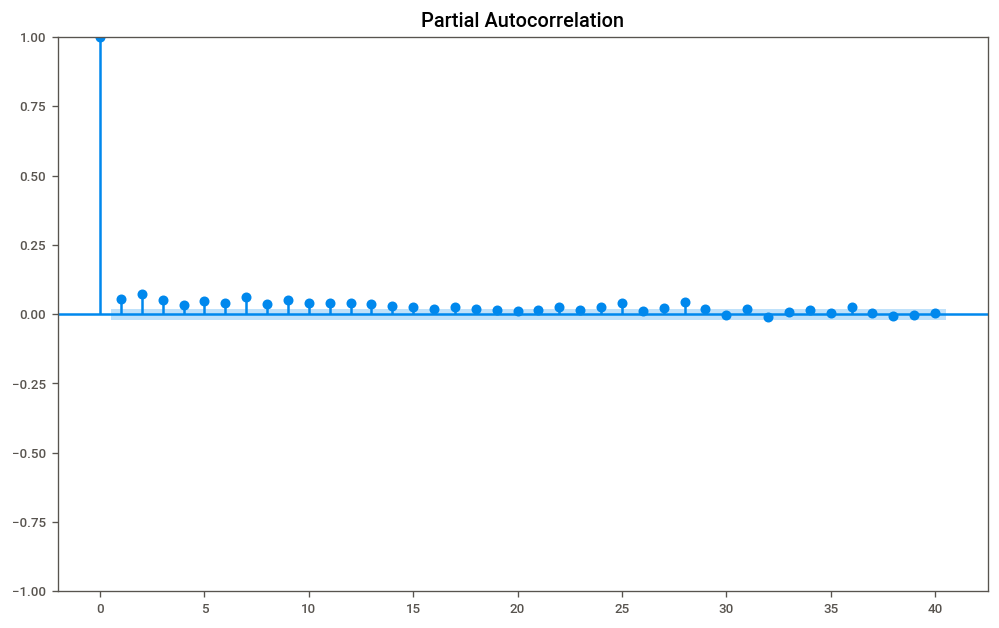

In [70]:
pacf = plot_pacf(clean_data)

# Spliting the Test and Train Data for Model Building

In [71]:
from sklearn.model_selection import train_test_split
# Split data into train and test sets
train_data, test_data = train_test_split(clean_data, test_size = 0.2, shuffle = False)

In [72]:
# Print the sizes of the train and test sets
print("Train set size:", len(train_data))
print("Test set size:", len(test_data))

Train set size: 8000
Test set size: 2000


In [73]:
from datetime import datetime, timedelta
train_dataset_end=datetime(2017,12,1)
test_dataset_end=datetime(2023,12,1)

In [74]:
train_data = clean_data[:train_dataset_end]
test_data = clean_data[train_dataset_end+timedelta(days=1):test_dataset_end]

In [75]:
train_data

Sales_volume
Date                    
1995-10-14          7.07
1995-10-15          8.35
1995-10-16          6.82
1995-10-17          6.86
1995-10-18          7.45
...                  ...
2017-11-27          7.75
2017-11-28         10.96
2017-11-29          8.85
2017-11-30          9.48
2017-12-01          7.75

[8085 rows x 1 columns]

In [76]:
test_data

Sales_volume
Date                    
2017-12-02          9.01
2017-12-03          9.11
2017-12-04          6.81
2017-12-05          7.84
2017-12-06          6.93
...                  ...
2023-02-24          9.13
2023-02-25          9.99
2023-02-26          8.84
2023-02-27          7.64
2023-02-28         10.61

[1915 rows x 1 columns]

# Model Building

**ARIMA**

ARIMA models are denoted as ARIMA(p,d,q), where p, d, and q are the orders of the AR, I, and MA components, respectively. For example, an ARIMA(2,1,1) model uses two past values of the time series, one difference, and one past error to forecast the future values.

In [77]:
from pmdarima.arima import auto_arima

In [78]:
# Convert train_data to float data type
train_data = train_data.astype('float')
test_data = test_data.astype('float')

In [79]:
# create and fit the model
model_ARIMA = ARIMA(train_data['Sales_volume'], order=(1, 1, 1), seasonal_order = None)
model_Arima_fit= model_ARIMA.fit()
model_Arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Sales_volume   No. Observations:                 8085
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14740.499
Date:                Tue, 25 Apr 2023   AIC                          29486.998
Time:                        15:52:04   BIC                          29507.991
Sample:                    10-14-1995   HQIC                         29494.180
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0064      0.011     -0.572      0.568      -0.028       0.016
ma.L1         -0.9714      0.003   -334.880      0.000      -0.977      -0.966
sigma2         2.2447      0.035     64.752      0.000       2.177       2.313
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               294.22
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

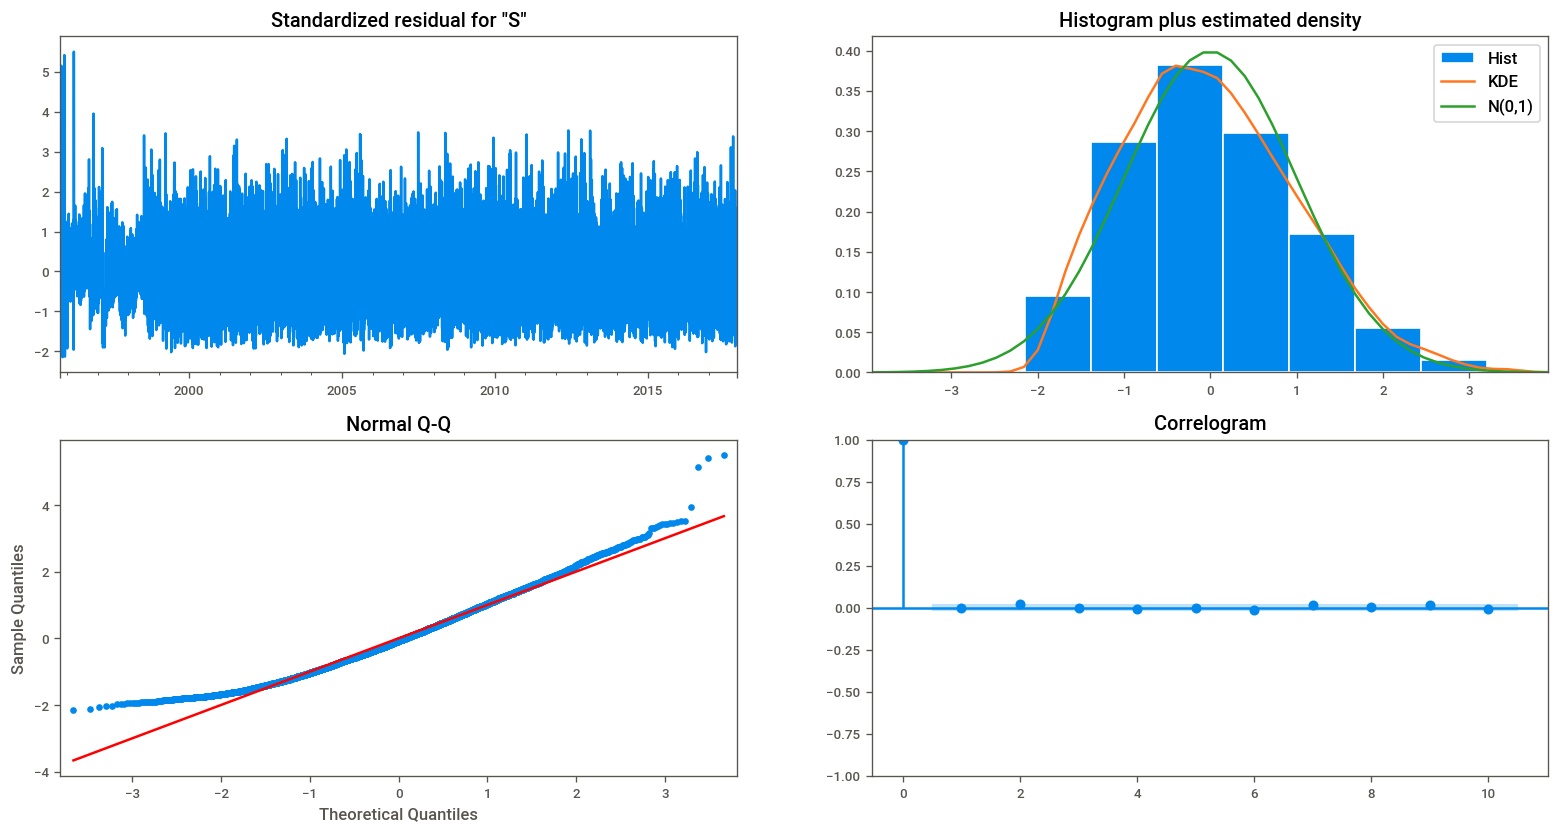

In [80]:
model_Arima_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [81]:
train_data = clean_data[:train_dataset_end]
test_data = clean_data[train_dataset_end+timedelta(days = 1):test_dataset_end]

In [82]:
# Prediction
pred_start_date = test_data.index[0]
pred_start_date

Timestamp('2017-12-02 00:00:00')

In [83]:
pred_end_date = test_data.index[-1]
pred_end_date

Timestamp('2023-02-28 00:00:00')

In [84]:
pred_ARIMA = model_Arima_fit.predict(start = pred_start_date, end = pred_end_date)
pred_ARIMA

2017-12-02    8.651630
2017-12-03    8.645836
2017-12-04    8.645873
2017-12-05    8.645873
2017-12-06    8.645873
                ...   
2023-02-24    8.645873
2023-02-25    8.645873
2023-02-26    8.645873
2023-02-27    8.645873
2023-02-28    8.645873
Freq: D, Name: predicted_mean, Length: 1915, dtype: float64

In [85]:
residuals = test_data['Sales_volume'] - pred_ARIMA
residuals

Date
2017-12-02    0.358370
2017-12-03    0.464164
2017-12-04   -1.835873
2017-12-05   -0.805873
2017-12-06   -1.715873
                ...   
2023-02-24    0.484127
2023-02-25    1.344127
2023-02-26    0.194127
2023-02-27   -1.005873
2023-02-28    1.964127
Length: 1915, dtype: float64

2023-03-01    8.645873
2023-03-02    8.645873
2023-03-03    8.645873
2023-03-04    8.645873
2023-03-05    8.645873
                ...   
2028-08-17    8.645873
2028-08-18    8.645873
2028-08-19    8.645873
2028-08-20    8.645873
2028-08-21    8.645873
Freq: D, Name: predicted_mean, Length: 2001, dtype: float64


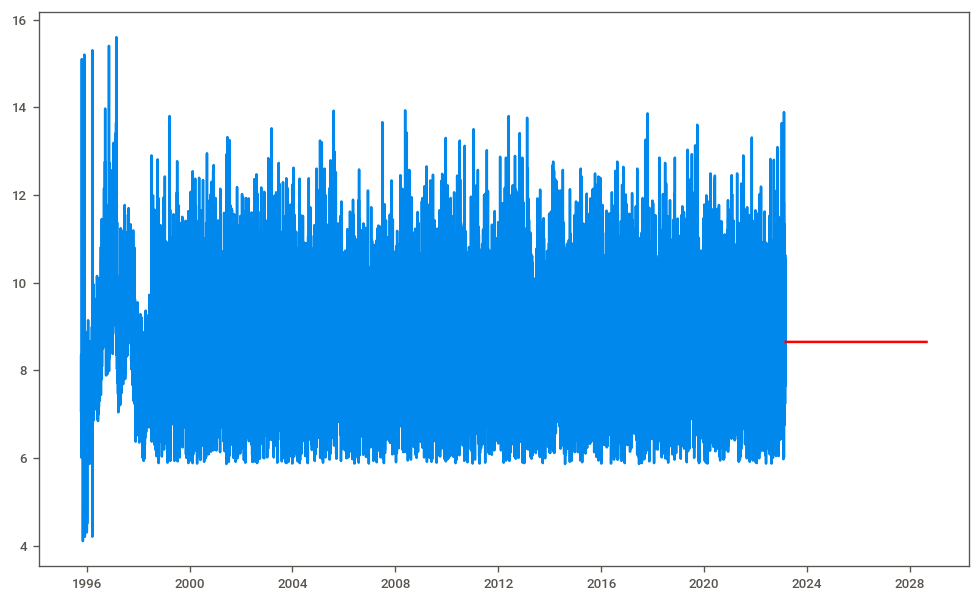

In [86]:
start_index = len(clean_data.Sales_volume)
start_index
end_index = start_index + 2000     ## predicting for approximately 5 years

forecast_ARIMA = model_Arima_fit.predict(start = start_index, end = end_index)

print(forecast_ARIMA)

# plot forecasts against actual outcomes
plt.plot(clean_data.Sales_volume)
plt.plot(forecast_ARIMA, color = 'red')

<AxesSubplot: ylabel='Density'>

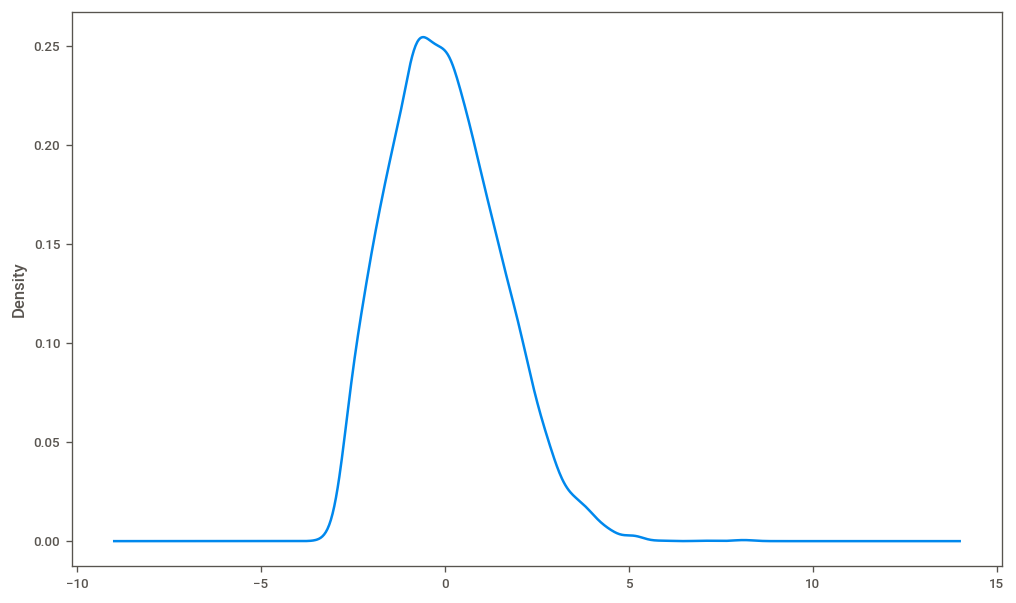

In [87]:
model_Arima_fit.resid.plot(kind='kde')

<AxesSubplot: xlabel='Date'>

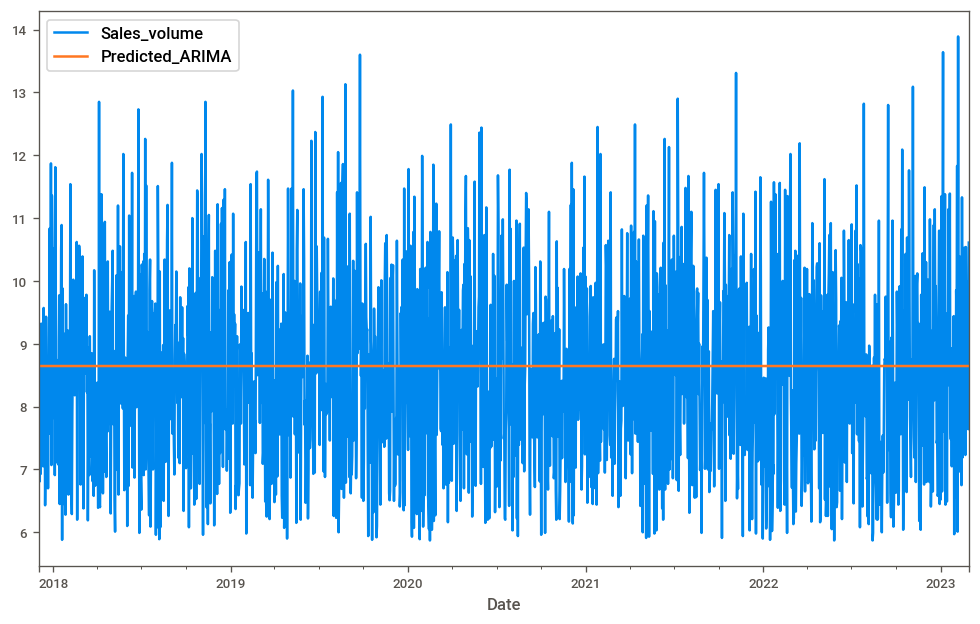

In [88]:
test_data['Predicted_ARIMA'] = pred_ARIMA
test_data[['Sales_volume','Predicted_ARIMA']].plot()

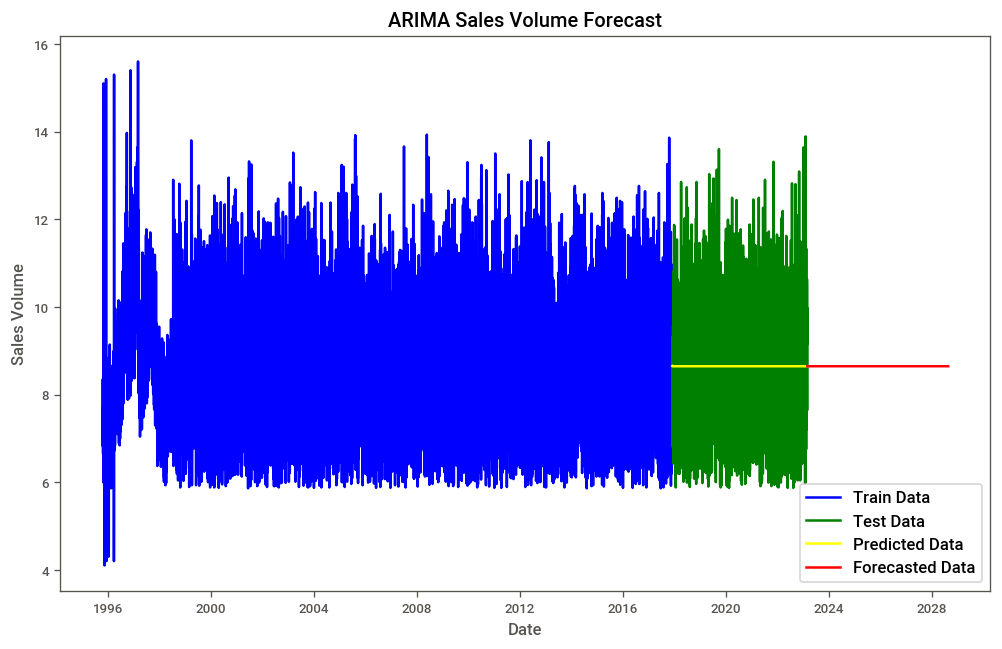

In [89]:
import matplotlib.pyplot as plt

# Plot train data in blue
plt.plot(train_data['Sales_volume'], color='blue', label='Train Data')

# Plot test data in green
plt.plot(test_data['Sales_volume'], color='green', label='Test Data')

# Plot forecasted values in yellow
plt.plot(pred_ARIMA, color='yellow', label='Predicted Data')

# Plot forecasted values in red
plt.plot(forecast_ARIMA, color='red', label='Forecasted Data')


# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.title('ARIMA Sales Volume Forecast')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


In [90]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Evaluate forecasts
rmse_arima = sqrt(mean_squared_error(test_data['Sales_volume'], pred_ARIMA))
print('Test RMSE: %.3f' % rmse_arima)

Test RMSE: 1.522


# SARIMA

(Seasonal Autoregressive Integrated Moving Average) is an extension of the ARIMA model that takes into account seasonality in the data. SARIMA models are used to model time series data that exhibit seasonal patterns or periodic fluctuations.

The term "SARIMA" refers to the following components:

Seasonal Autoregression (SAR): SAR models are similar to AR models, but they use past values of the time series that are separated by a fixed seasonal interval. An SAR(P) model expresses the current value of the time series as a linear combination of the P most recent values that are separated by a seasonal interval.

Seasonal Moving Average (SMA): SMA models are similar to MA models, but they use past errors that are separated by a fixed seasonal interval. An SMA(Q) model expresses the current value of the time series as a linear combination of the Q most recent errors that are separated by a seasonal interval.

Seasonal Integration (SI): SI models are similar to I models, but they take seasonal differences between observations. An SI(D) model takes seasonal differences of order D.

Seasonal period (s): SARIMA models require specification of the length of the seasonal period, denoted by s. For example, if the data is monthly and exhibits annual seasonality, s=12.

In [91]:
## create a SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [92]:
train_data = clean_data[:train_dataset_end]
test_data = clean_data[train_dataset_end+timedelta(days=1):test_dataset_end]

# Convert train_data to float data type
train_data = train_data.astype('float')
test_data = test_data.astype('float')

model_SARIMA = SARIMAX(train_data['Sales_volume'], order = (3,0,5), seasonal_order = (0,1,0,12))

model_SARIMA_fit = model_SARIMA.fit()
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Sales_volume   No. Observations:                 8085
Model:             SARIMAX(3, 0, 5)x(0, 1, [], 12)   Log Likelihood              -17360.399
Date:                             Tue, 25 Apr 2023   AIC                          34738.799
Time:                                     15:52:30   BIC                          34801.765
Sample:                                 10-14-1995   HQIC                         34760.341
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0197      1.320     -0.015      0.988      -2.607       2.568
ar.L2         -0.0543      1.287     -0.042      0.966      -2.577       2.468
ar.L3         -0.0755      1.233     -0.061      0.951      -2.493       2.342
ma.L1          0.0049      1.320      0.004      0.997      -2.583       2.593
ma.L2          0.0799      1.294      0.062      0.951      -2.456       2.616
ma.L3          0.0737      1.246      0.059      0.953      -2.368       2.516
ma.L4         -0.0031      0.046     -0.068      0.946      -0.092       0.086
ma.L5         -0.0070      0.035     -0.201      0.841      -0.075       0.061
sigma2         4.3189      0.065     66.311      0.000       4.191       4.447
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.31
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
# Define prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print("pred_start_date: ", pred_start_date)
print("pred_end_date: ", pred_end_date)

pred_start_date:  2017-12-02 00:00:00
pred_end_date:  2023-02-28 00:00:00


In [94]:
pred_SARIMA = model_SARIMA_fit.predict(start = pred_start_date, end = pred_end_date)
pred_SARIMA

2017-12-02    10.211170
2017-12-03     6.399324
2017-12-04     7.164405
2017-12-05     8.816614
2017-12-06     7.414579
                ...    
2023-02-24     7.164403
2023-02-25     8.816614
2023-02-26     7.414580
2023-02-27    10.133867
2023-02-28     7.691441
Freq: D, Name: predicted_mean, Length: 1915, dtype: float64

In [95]:
residuals_SARIMA = test_data['Sales_volume'] - pred_SARIMA
residuals_SARIMA

Date
2017-12-02   -1.201170
2017-12-03    2.710676
2017-12-04   -0.354405
2017-12-05   -0.976614
2017-12-06   -0.484579
                ...   
2023-02-24    1.965597
2023-02-25    1.173386
2023-02-26    1.425420
2023-02-27   -2.493867
2023-02-28    2.918559
Length: 1915, dtype: float64

<AxesSubplot: xlabel='Date'>

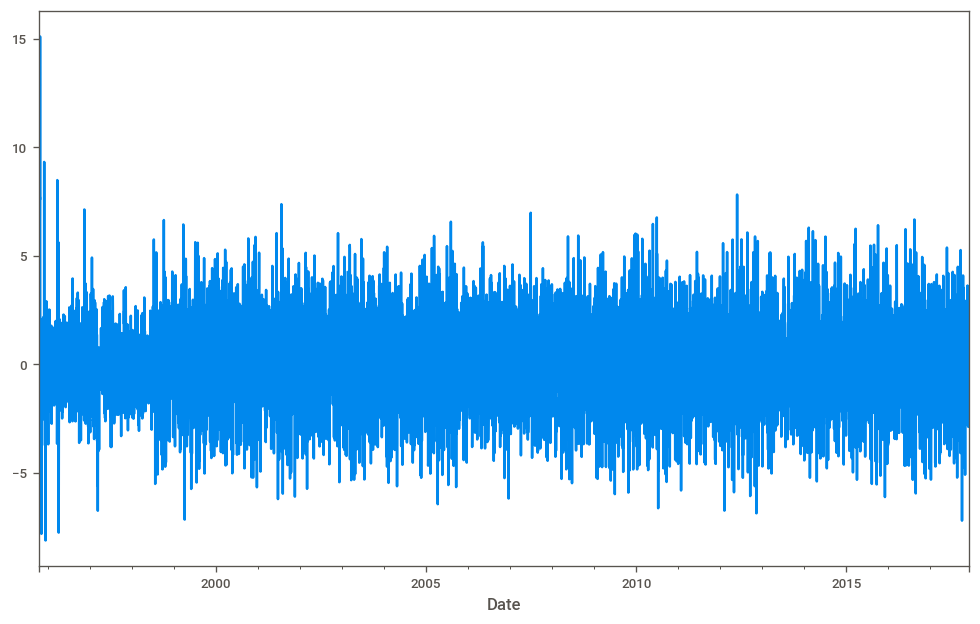

In [96]:
model_SARIMA_fit.resid.plot()

<AxesSubplot: ylabel='Density'>

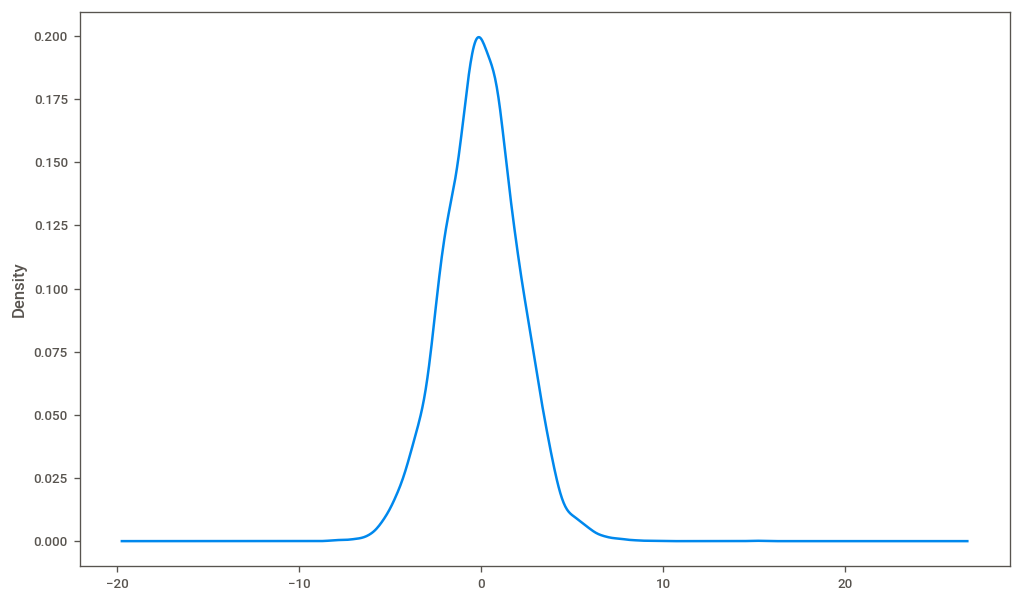

In [97]:
model_SARIMA_fit.resid.plot(kind='kde')

In [98]:
# Define start and end indices for forecast
start_index = len(clean_data.Sales_volume)
end_index = start_index + 2000

In [99]:
# Forecast using SARIMA model
forecast_SARIMA = model_SARIMA_fit.predict(start=start_index, end=end_index)

print(forecast_SARIMA)

2023-03-01     7.749416
2023-03-02    10.959641
2023-03-03     8.849930
2023-03-04     9.480065
2023-03-05     7.750030
                ...    
2028-08-17     7.750030
2028-08-18    10.211171
2028-08-19     6.399317
2028-08-20     7.164403
2028-08-21     8.816614
Freq: D, Name: predicted_mean, Length: 2001, dtype: float64


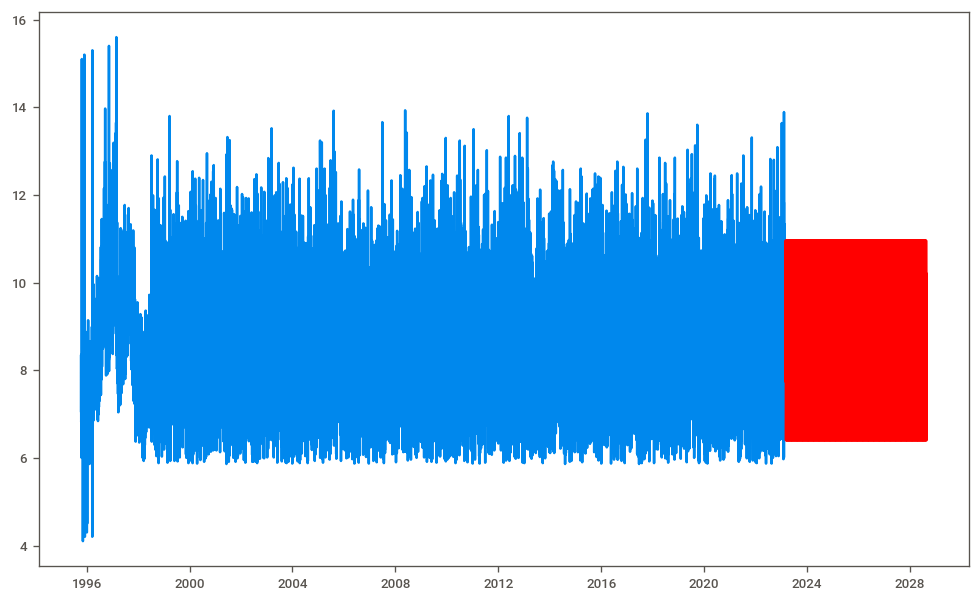

In [100]:
# plot forecasts against actual outcomes
plt.plot(clean_data.Sales_volume)
plt.plot(forecast_SARIMA, color = 'red')

<AxesSubplot: xlabel='Date'>

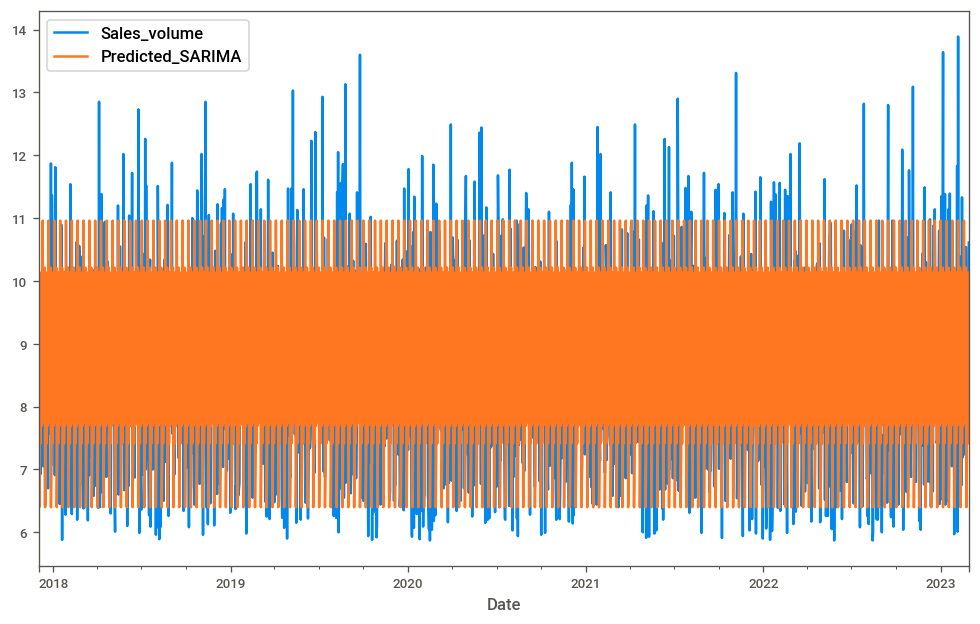

In [101]:
# Add predicted values to test data
test_data['Predicted_SARIMA'] = pred_SARIMA

# Plot actual vs predicted values
test_data[['Sales_volume', 'Predicted_SARIMA']].plot()

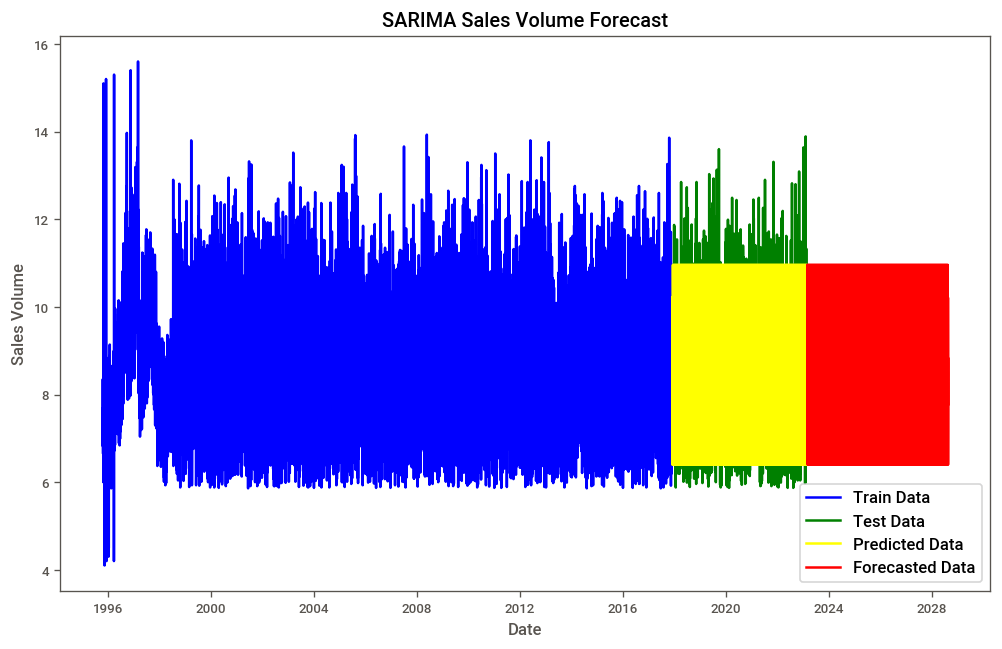

In [102]:
import matplotlib.pyplot as plt

# Plot train data in blue
plt.plot(train_data['Sales_volume'], color='blue', label='Train Data')

# Plot test data in green
plt.plot(test_data['Sales_volume'], color='green', label='Test Data')

# Plot forecasted values in yellow
plt.plot(pred_SARIMA, color='yellow', label='Predicted Data')

# Plot forecasted values in red
plt.plot(forecast_SARIMA, color='red', label='Forecasted Data')


# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.title('SARIMA Sales Volume Forecast')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


# SARIMAX

(Seasonal Autoregressive Integrated Moving Average with Exogenous Variables) is an extension of the SARIMA model that incorporates exogenous variables or external predictors into the model. Exogenous variables are independent variables that may be related to the time series being forecasted, but are not part of the time series itself.

The term "SARIMAX" refers to the following components:

Seasonal Autoregression (SAR): SAR models are similar to AR models, but they use past values of the time series that are separated by a fixed seasonal interval. An SAR(P) model expresses the current value of the time series as a linear combination of the P most recent values that are separated by a seasonal interval.

Seasonal Moving Average (SMA): SMA models are similar to MA models, but they use past errors that are separated by a fixed seasonal interval. An SMA(Q) model expresses the current value of the time series as a linear combination of the Q most recent errors that are separated by a seasonal interval.

Seasonal Integration (SI): SI models are similar to I models, but they take seasonal differences between observations. An SI(D) model takes seasonal differences of order D.

Exogenous variables (X): SARIMAX models incorporate exogenous variables into the model. These variables can be continuous or categorical and may be related to the time series being forecasted.

Seasonal period (s): SARIMAX models require specification of the length of the seasonal period, denoted by s.

In [103]:
# create and fit the SARIMAX model
model_SARIMAX = SARIMAX(train_data['Sales_volume'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
SARIMAX_fit = model_SARIMAX.fit()
SARIMAX_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Sales_volume   No. Observations:                 8085
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -14761.927
Date:                            Tue, 25 Apr 2023   AIC                          29533.853
Time:                                    15:53:39   BIC                          29568.834
Sample:                                10-14-1995   HQIC                         29545.821
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0063      0.011     -0.558      0.577      -0.028       0.016
ma.L1         -0.9719      0.003   -333.080      0.000      -0.978      -0.966
ar.S.L12       0.0143      0.011      1.300      0.194      -0.007       0.036
ma.S.L12      -0.9997      0.015    -66.695      0.000      -1.029      -0.970
sigma2         2.2472      0.049     45.678      0.000       2.151       2.344
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               249.04
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
# Prediction
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [105]:
pred_start_date

Timestamp('2017-12-02 00:00:00')

In [106]:
pred_end_date

Timestamp('2023-02-28 00:00:00')

In [107]:
pred_SARIMAX = SARIMAX_fit.predict(start = pred_start_date, end = pred_end_date)
pred_SARIMAX

2017-12-02    8.680630
2017-12-03    8.638383
2017-12-04    8.653938
2017-12-05    8.605424
2017-12-06    8.671492
                ...   
2023-02-24    9.011166
2023-02-25    8.938174
2023-02-26    9.025930
2023-02-27    8.938362
2023-02-28    9.023409
Freq: D, Name: predicted_mean, Length: 1915, dtype: float64

In [108]:
residuals = test_data['Sales_volume'] - pred_SARIMAX
residuals

Date
2017-12-02    0.329370
2017-12-03    0.471617
2017-12-04   -1.843938
2017-12-05   -0.765424
2017-12-06   -1.741492
                ...   
2023-02-24    0.118834
2023-02-25    1.051826
2023-02-26   -0.185930
2023-02-27   -1.298362
2023-02-28    1.586591
Length: 1915, dtype: float64

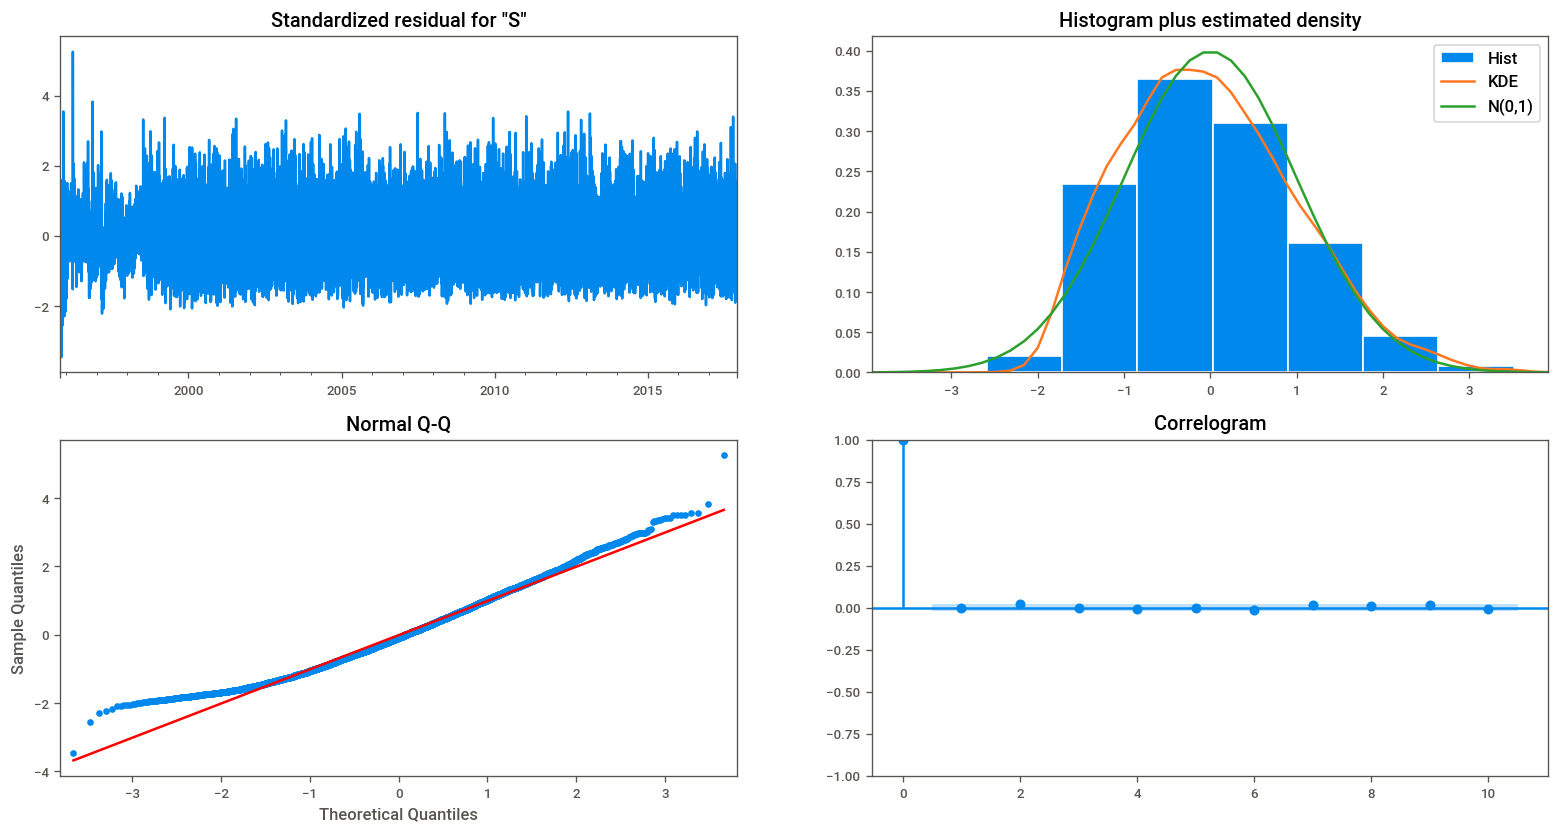

In [109]:
SARIMAX_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [110]:
start_index = len(clean_data.Sales_volume)
start_index
end_index = start_index + 2000

forecast_SARIMAX = SARIMAX_fit.predict(start = start_index, end = end_index)

print(forecast_SARIMAX)

2023-03-01    8.986081
2023-03-02    8.988250
2023-03-03    8.939235
2023-03-04    8.986518
2023-03-05    9.042438
                ...   
2028-08-17    9.393419
2028-08-18    9.343025
2028-08-19    9.359827
2028-08-20    9.364262
2028-08-21    9.291270
Freq: D, Name: predicted_mean, Length: 2001, dtype: float64


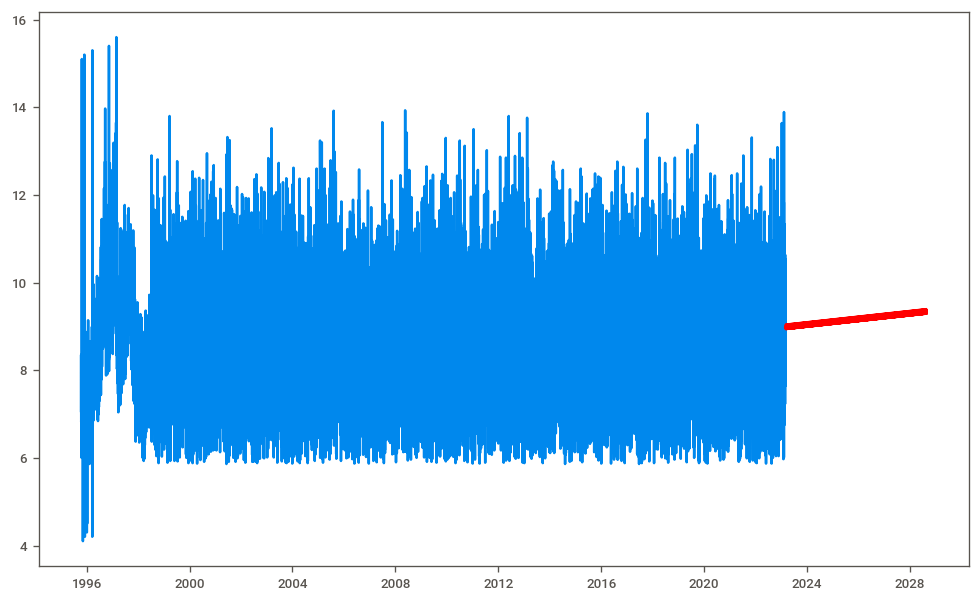

In [111]:
# plot forecasts against actual outcomes
plt.plot(clean_data.Sales_volume)
plt.plot(forecast_SARIMAX, color = 'red')

<AxesSubplot: xlabel='Date'>

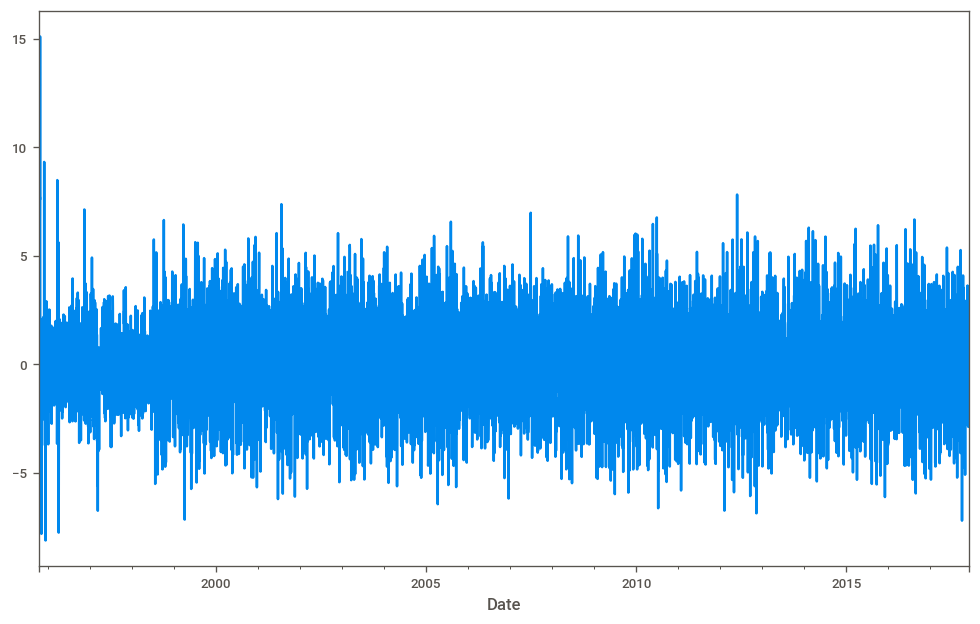

In [112]:
model_SARIMA_fit.resid.plot()

<AxesSubplot: ylabel='Density'>

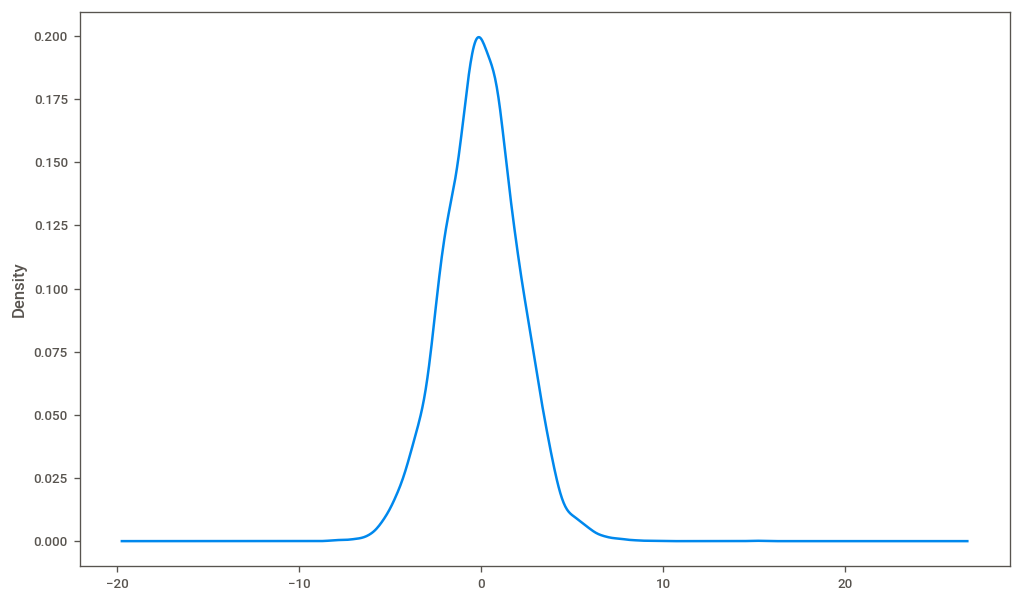

In [113]:
model_SARIMA_fit.resid.plot(kind='kde')

<AxesSubplot: xlabel='Date'>

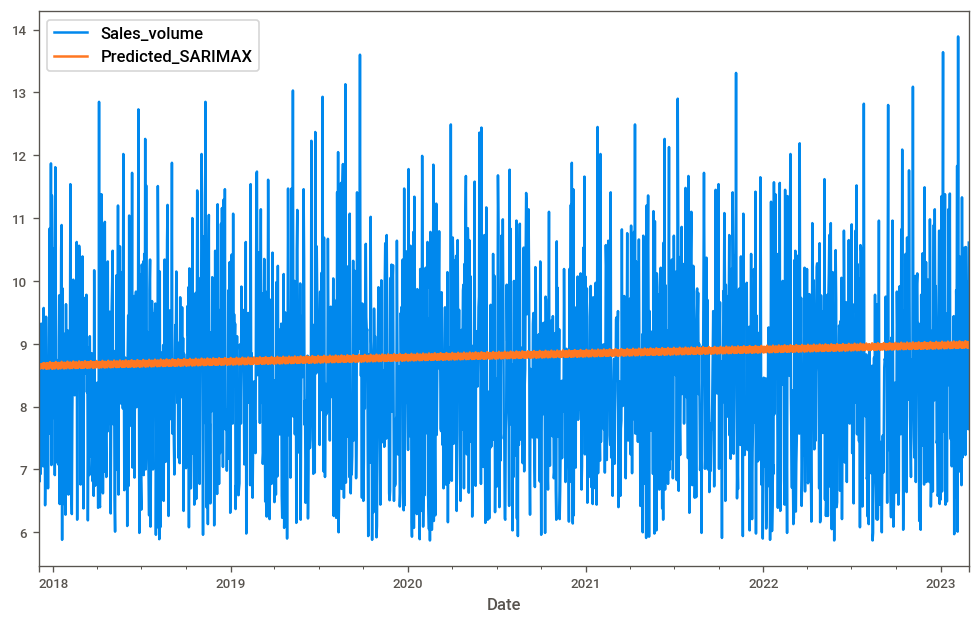

In [114]:
# Add predicted values to test data
test_data['Predicted_SARIMAX'] = pred_SARIMAX

# Plot actual vs predicted values
test_data[['Sales_volume', 'Predicted_SARIMAX']].plot()

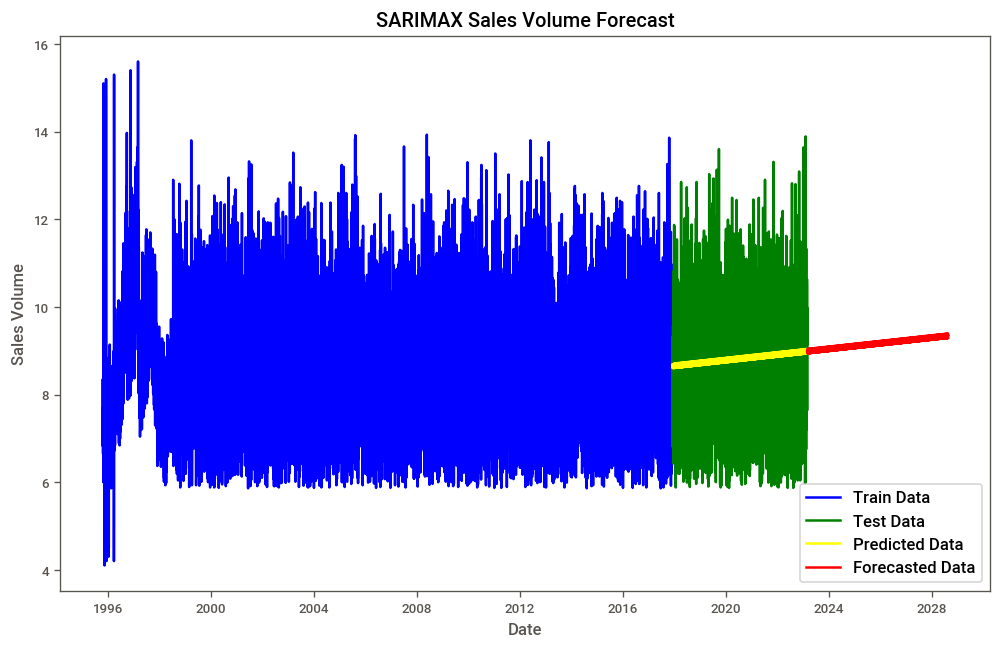

In [115]:
import matplotlib.pyplot as plt

# Plot train data in blue
plt.plot(train_data['Sales_volume'], color='blue', label='Train Data')

# Plot test data in green
plt.plot(test_data['Sales_volume'], color='green', label='Test Data')

# Plot forecasted values in yellow
plt.plot(pred_SARIMAX, color='yellow', label='Predicted Data')

# Plot forecasted values in red
plt.plot(forecast_SARIMAX, color='red', label='Forecasted Data')


# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.title('SARIMAX Sales Volume Forecast')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


# Adaptive Exponential Smoothing (AES)

Adaptive Exponential Smoothing (AES) is a time series forecasting method that uses an adaptive smoothing parameter to adjust the level of smoothing based on the recent trends and patterns in the time series. The AES model assumes that the future values of a time series are a function of the current and past values, and that the level of smoothing should be adjusted over time to capture changing trends and patterns.

In [116]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [117]:
# create and fit the model
model_AES = ExponentialSmoothing(train_data['Sales_volume'], trend = 'add', damped = True, 
                                 seasonal = 'add', seasonal_periods = 12)
model_fit = model_AES.fit()

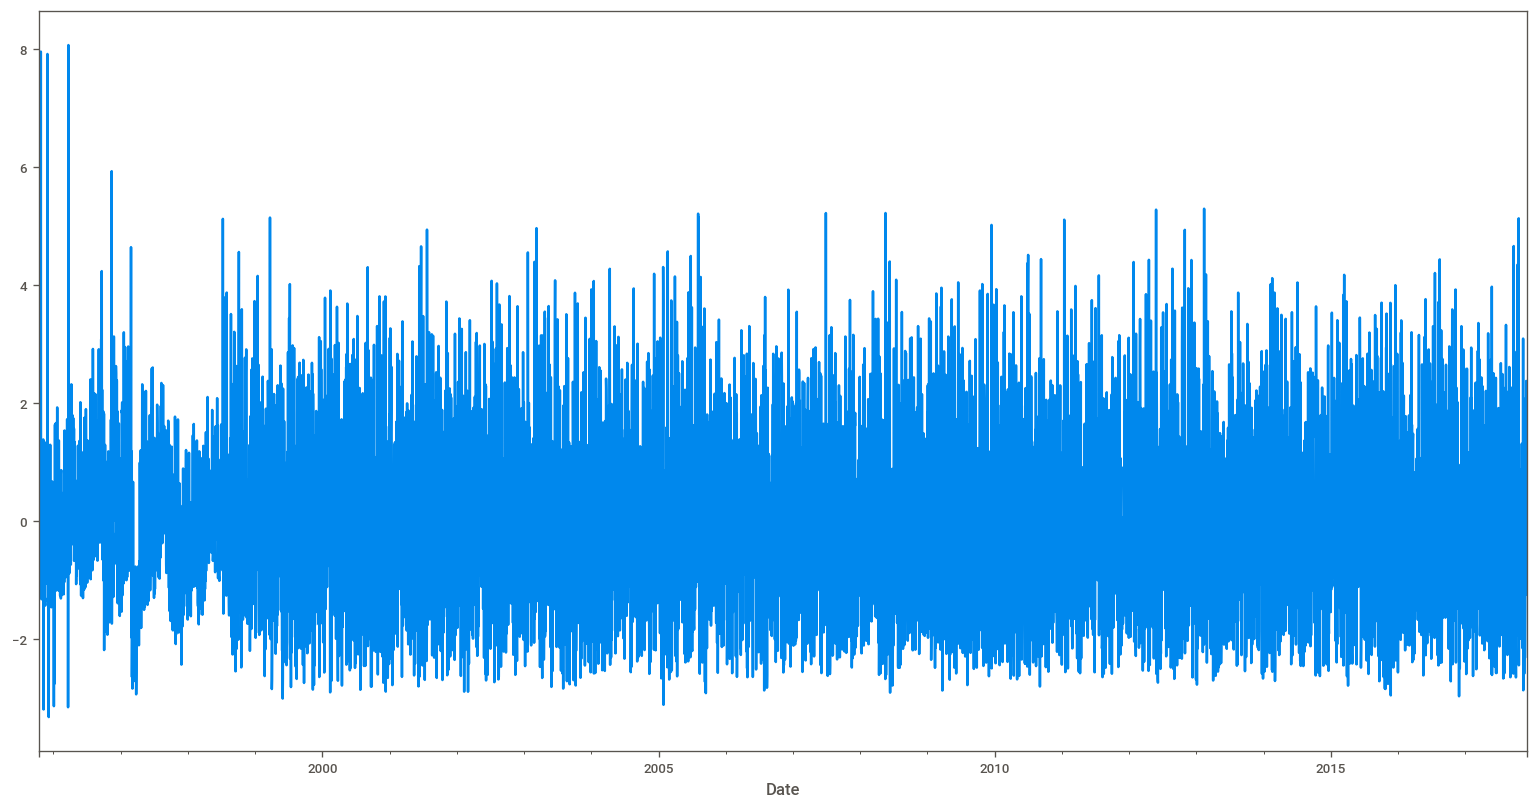

In [118]:
residuals = model_fit.resid 
residuals.plot(figsize=(16, 8)) 
plt.show()

In [119]:
# make predictions
pred_AES = model_fit.predict(start = pred_start_date, end = pred_end_date)
pred_AES 

2017-12-02    8.649780
2017-12-03    8.666557
2017-12-04    8.671074
2017-12-05    8.598283
2017-12-06    8.686390
                ...   
2023-02-24    8.671074
2023-02-25    8.598283
2023-02-26    8.686390
2023-02-27    8.597468
2023-02-28    8.682705
Freq: D, Length: 1915, dtype: float64

In [120]:
# calculate the residuals
residuals = test_data['Sales_volume'] - pred_AES
residuals

Date
2017-12-02    0.360220
2017-12-03    0.443443
2017-12-04   -1.861074
2017-12-05   -0.758283
2017-12-06   -1.756390
                ...   
2023-02-24    0.458926
2023-02-25    1.391717
2023-02-26    0.153610
2023-02-27   -0.957468
2023-02-28    1.927295
Length: 1915, dtype: float64

<AxesSubplot: xlabel='Date'>

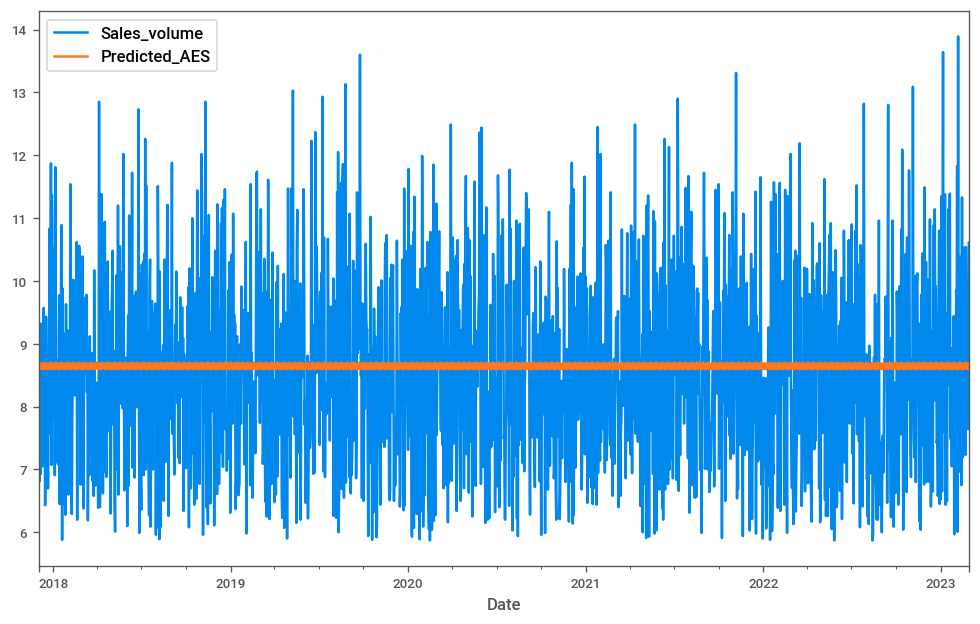

In [121]:
# plot the predicted and actual values
test_data['Predicted_AES'] = pred_AES
test_data[['Sales_volume','Predicted_AES']].plot()

In [122]:
start_index = len(clean_data.Sales_volume)
start_index
end_index = start_index + 2000

forecast_AES = model_fit.predict(start = start_index, end = end_index)

print(forecast_AES)


2023-03-01    8.645099
2023-03-02    8.646851
2023-03-03    8.597958
2023-03-04    8.644972
2023-03-05    8.700585
                ...   
2028-08-17    8.700585
2028-08-18    8.649780
2028-08-19    8.666557
2028-08-20    8.671074
2028-08-21    8.598283
Freq: D, Length: 2001, dtype: float64


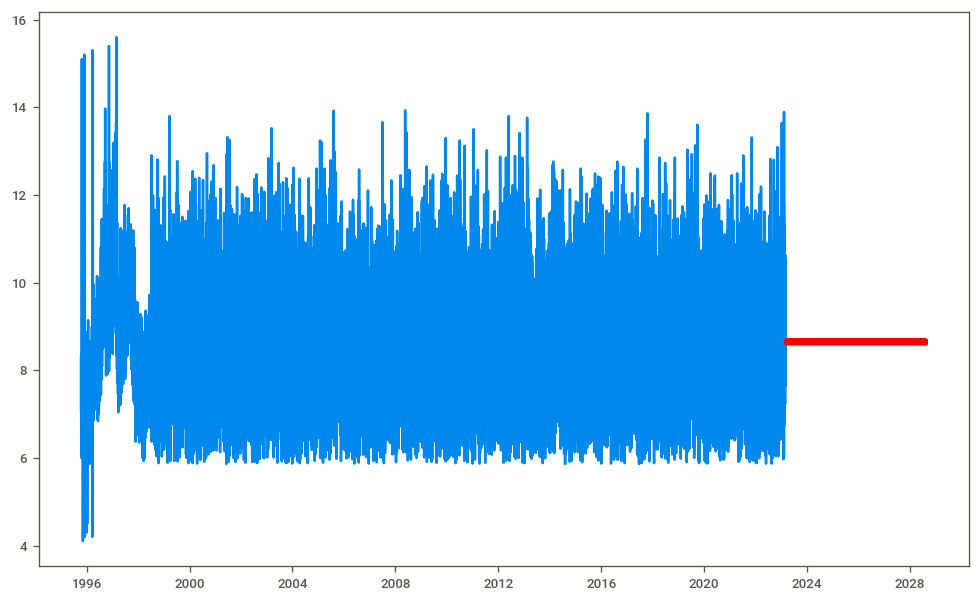

In [123]:
# plot forecasts against actual outcomes
plt.plot(clean_data.Sales_volume)
plt.plot(forecast_AES, color = 'red')

<AxesSubplot: xlabel='Date'>

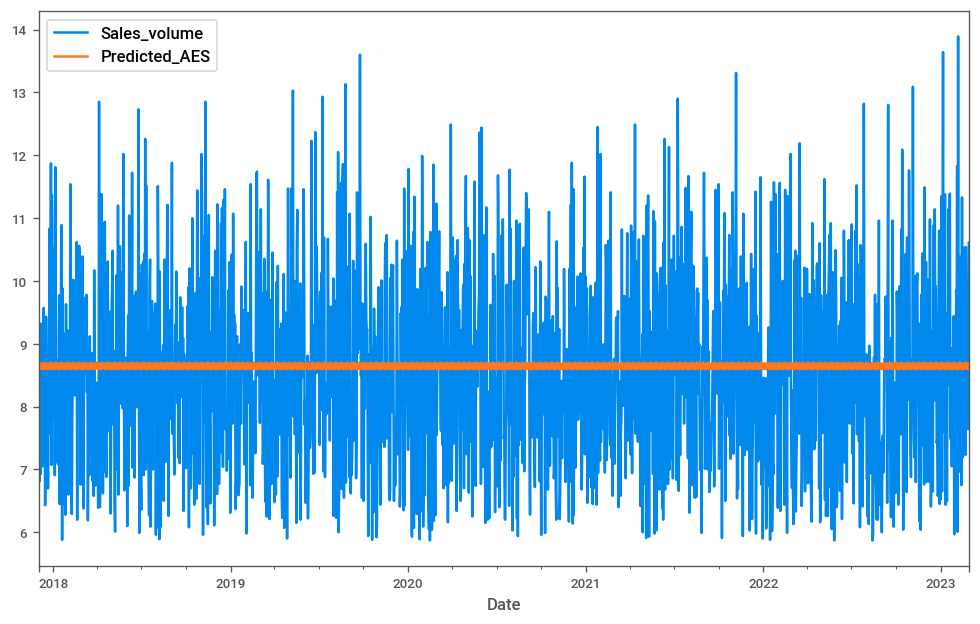

In [124]:
# Add predicted values to test data
test_data['Predicted_AES'] = pred_AES
# Plot actual vs predicted values
test_data[['Sales_volume', 'Predicted_AES']].plot()

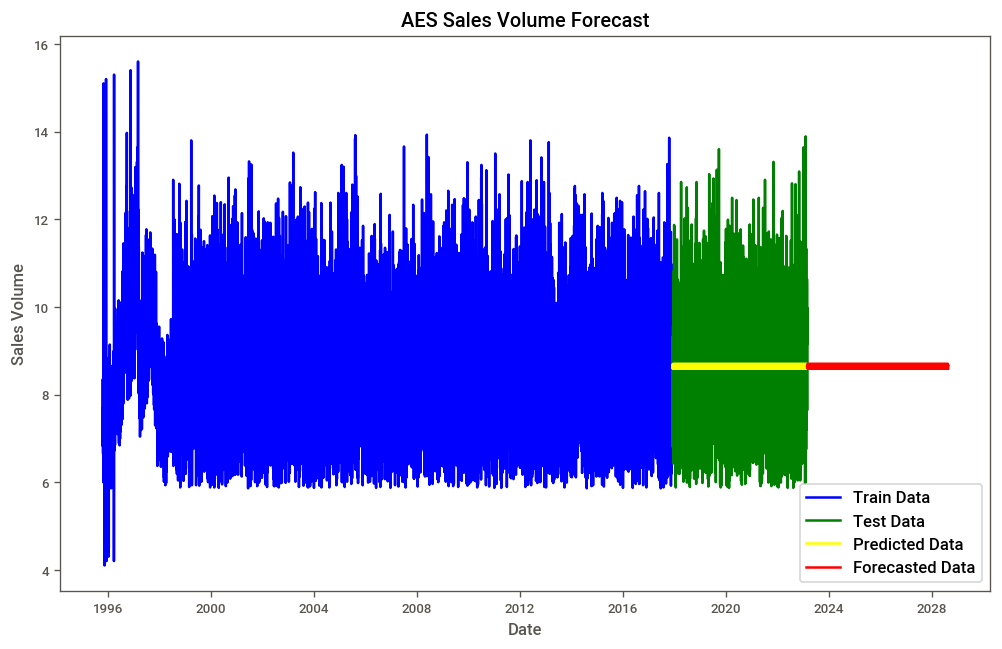

In [125]:
import matplotlib.pyplot as plt

# Plot train data in blue
plt.plot(train_data['Sales_volume'], color='blue', label='Train Data')

# Plot test data in green
plt.plot(test_data['Sales_volume'], color='green', label='Test Data')

# Plot forecasted values in yellow
plt.plot(pred_AES, color='yellow', label='Predicted Data')

# Plot forecasted values in red
plt.plot(forecast_AES, color='red', label='Forecasted Data')


# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.title('AES Sales Volume Forecast')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


# Moving Average (MA)

Moving Average (MA) is a time series forecasting method that uses the past errors (or residuals) of a time series model to generate future predictions. The MA model assumes that the future values of a time series are a function of the past errors or residuals, and that the errors follow a white noise process with constant variance.


In [126]:
from statsmodels.tsa.arima.model import ARIMA

In [127]:
# create a rolling mean series with window size 5
rolling_mean = clean_data['Sales_volume'].rolling(window = 5).mean()


In [128]:
# create a new DataFrame with the rolling mean series
rolling_mean_data = pd.DataFrame({'Sales_volume': rolling_mean}, index = data.index)

# drop any rows with NaN values
rolling_mean_data.dropna(inplace = True)

In [129]:
# fit the ARIMA model
model = ARIMA(rolling_mean_data, order = (0, 0, 1))
model_fit = model.fit()

In [130]:
# print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Sales_volume   No. Observations:                 9996
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -8068.726
Date:                Tue, 25 Apr 2023   AIC                          16143.452
Time:                        15:54:03   BIC                          16165.082
Sample:                    10-18-1995   HQIC                         16150.774
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5458      0.009    941.243      0.000       8.528       8.564
ma.L1          0.6445      0.007     87.533      0.000       0.630       0.659
sigma2         0.2942      0.004     74.360      0.0

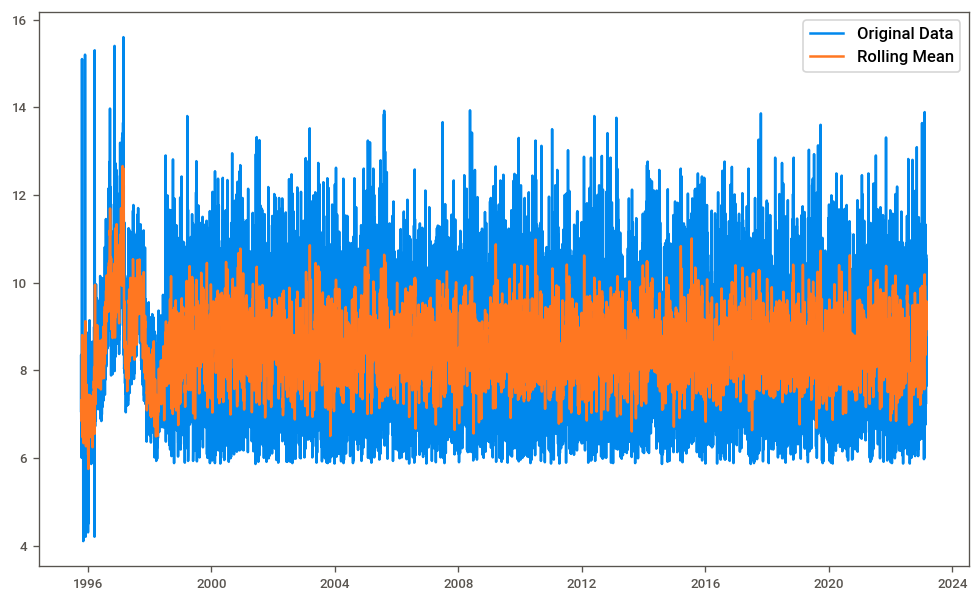

In [131]:
# plot the original data and the rolling mean
plt.plot(clean_data['Sales_volume'], label = 'Original Data')
plt.plot(rolling_mean_data['Sales_volume'], label = 'Rolling Mean')
plt.legend()
plt.show()

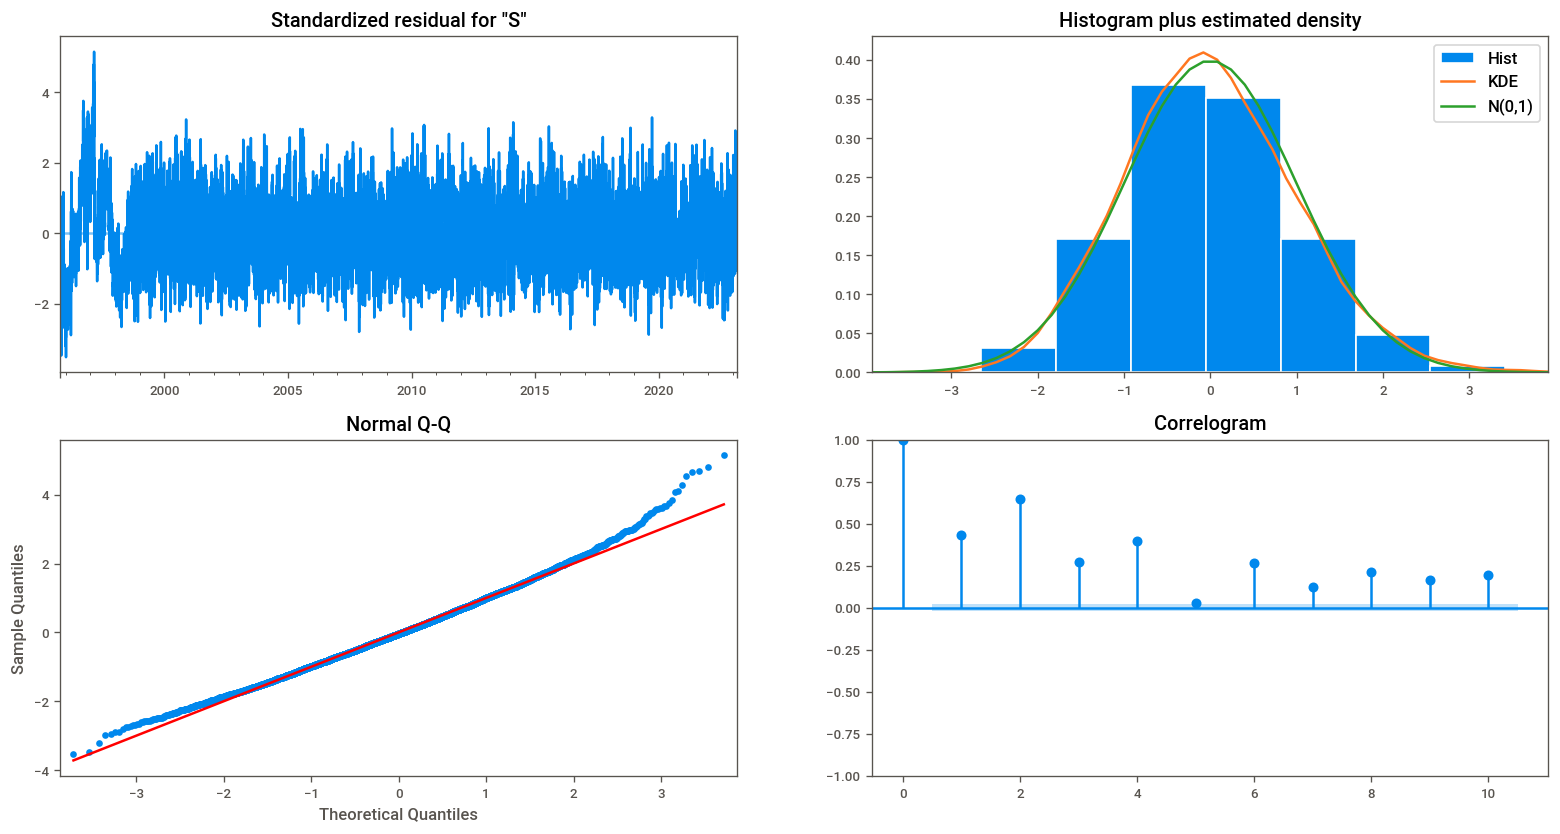

In [132]:
# plot the model diagnostics
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [133]:
# make predictions
pred_MA = model_fit.predict(start = pred_start_date, end=pred_end_date, typ ='levels')
pred_MA

2017-12-02    8.732061
2017-12-03    8.853798
2017-12-04    8.536882
2017-12-05    8.478180
2017-12-06    8.304622
                ...   
2023-02-24    8.613490
2023-02-25    8.744604
2023-02-26    8.874071
2023-02-27    8.998155
2023-02-28    8.544386
Freq: D, Name: predicted_mean, Length: 1915, dtype: float64

In [134]:
# calculate the residuals
residuals_MA = test_data['Sales_volume'] - pred_MA
residuals_MA

Date
2017-12-02    0.277939
2017-12-03    0.256202
2017-12-04   -1.726882
2017-12-05   -0.638180
2017-12-06   -1.374622
                ...   
2023-02-24    0.516510
2023-02-25    1.245396
2023-02-26   -0.034071
2023-02-27   -1.358155
2023-02-28    2.065614
Length: 1915, dtype: float64

In [135]:
start_index = len(clean_data.Sales_volume)
start_index
end_index = start_index + 2000

forecast_MA = model_fit.predict(start = start_index, end = end_index)

print(forecast_MA.head())

2023-03-05    8.545775
2023-03-06    8.545775
2023-03-07    8.545775
2023-03-08    8.545775
2023-03-09    8.545775
Freq: D, Name: predicted_mean, dtype: float64


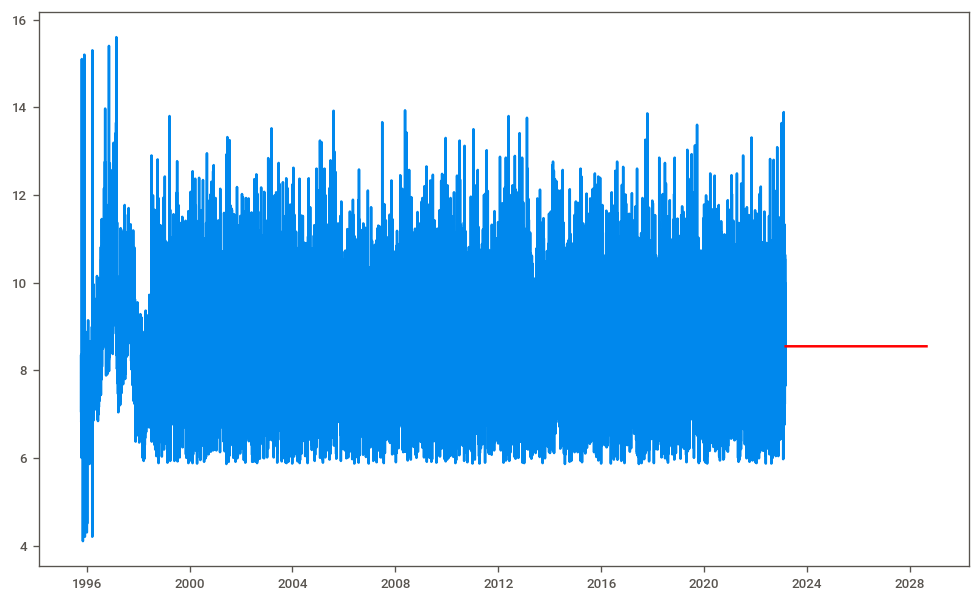

In [136]:
# plot forecasts against actual outcomes
plt.plot(clean_data.Sales_volume)
plt.plot(forecast_MA, color = 'red')  

<AxesSubplot: xlabel='Date'>

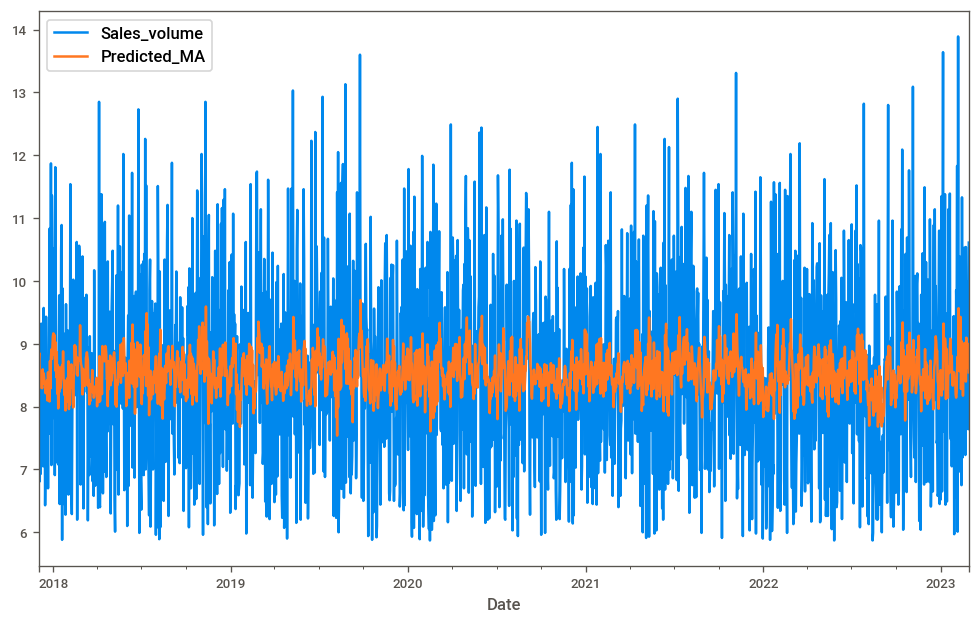

In [137]:
# plot the predicted and actual values
test_data['Predicted_MA'] = pred_MA
test_data[['Sales_volume','Predicted_MA']].plot()

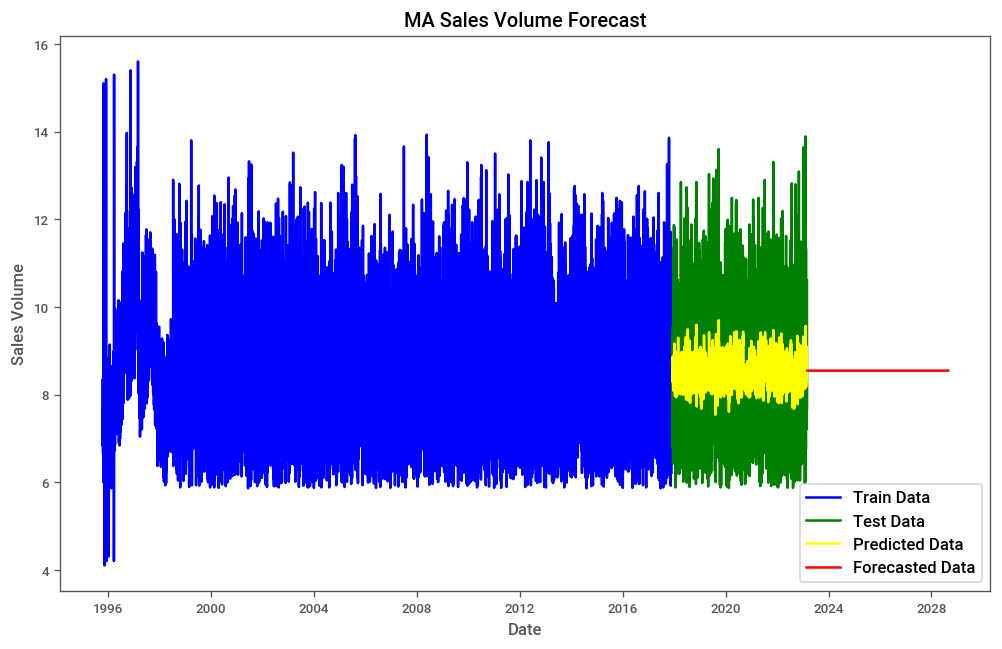

In [138]:
import matplotlib.pyplot as plt

# Plot train data in blue
plt.plot(train_data['Sales_volume'], color='blue', label='Train Data')

# Plot test data in green
plt.plot(test_data['Sales_volume'], color='green', label='Test Data')

# Plot forecasted values in yellow
plt.plot(pred_MA, color='yellow', label='Predicted Data')

# Plot forecasted values in red
plt.plot(forecast_MA, color='red', label='Forecasted Data')


# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.title('MA Sales Volume Forecast')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


# Simple Exponential Smoothing (SES)

Simple Exponential Smoothing (SES) is a time series forecasting method that uses a single smoothing parameter to generate a smoothed series and make future predictions. The SES model assumes that the next value in the time series is a function of the current value and an error term.

In [139]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [140]:
model_SimpleExp = SimpleExpSmoothing(train_data['Sales_volume'])
SimpleExp_fit = model_SimpleExp.fit()
SimpleExp_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:           Sales_volume   No. Observations:                 8085
Model:             SimpleExpSmoothing   SSE                          18147.333
Optimized:                       True   AIC                           6540.828
Trend:                           None   BIC                           6554.824
Seasonal:                        None   AICC                          6540.833
Seasonal Periods:                None   Date:                 Tue, 25 Apr 2023
Box-Cox:                        False   Time:                         15:54:09
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0280590                alpha                 True
initial_level              7.2236349                  l.0                 True
------------------------------------------------------------------------------
"""

In [141]:
# create and fit the model
pred_SimpleExp = SimpleExp_fit.predict(start = pred_start_date, end = pred_end_date)
pred_SimpleExp

2017-12-02    8.646773
2017-12-03    8.646773
2017-12-04    8.646773
2017-12-05    8.646773
2017-12-06    8.646773
                ...   
2023-02-24    8.646773
2023-02-25    8.646773
2023-02-26    8.646773
2023-02-27    8.646773
2023-02-28    8.646773
Freq: D, Length: 1915, dtype: float64

In [142]:
residuals_SimpleExp = test_data['Sales_volume'] - pred_SimpleExp
residuals_SimpleExp

Date
2017-12-02    0.363227
2017-12-03    0.463227
2017-12-04   -1.836773
2017-12-05   -0.806773
2017-12-06   -1.716773
                ...   
2023-02-24    0.483227
2023-02-25    1.343227
2023-02-26    0.193227
2023-02-27   -1.006773
2023-02-28    1.963227
Length: 1915, dtype: float64

In [143]:
start_index = len(clean_data.Sales_volume)
start_index
end_index = start_index + 2000

forecast_SimpleExp = model_fit.predict(start = start_index, end = end_index)

print(forecast_SimpleExp)

2023-03-05    8.545775
2023-03-06    8.545775
2023-03-07    8.545775
2023-03-08    8.545775
2023-03-09    8.545775
                ...   
2028-08-21    8.545775
2028-08-22    8.545775
2028-08-23    8.545775
2028-08-24    8.545775
2028-08-25    8.545775
Freq: D, Name: predicted_mean, Length: 2001, dtype: float64


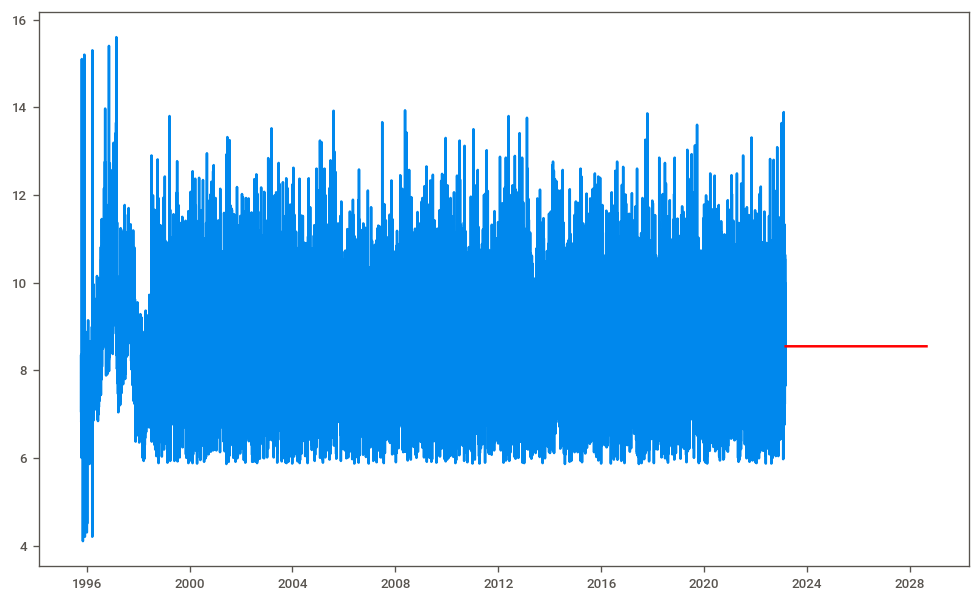

In [144]:
# plot forecasts against actual outcomes
plt.plot(clean_data.Sales_volume)
plt.plot(forecast_SimpleExp, color = 'red')  

<AxesSubplot: xlabel='Date'>

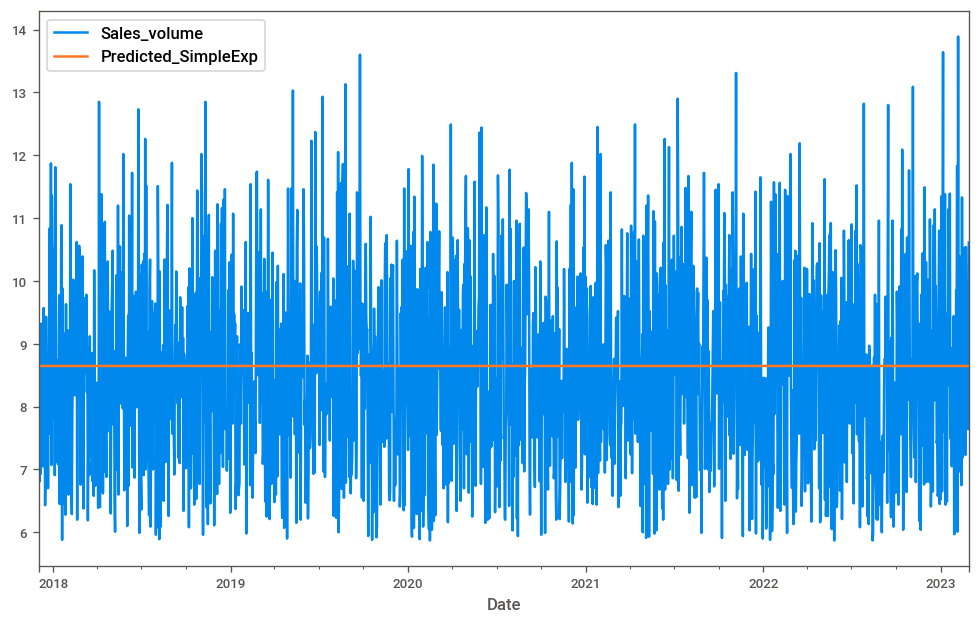

In [145]:
# Add predicted values to test data
test_data['Predicted_SimpleExp'] = pred_SimpleExp

# Plot actual vs predicted values
test_data[['Sales_volume', 'Predicted_SimpleExp']].plot()


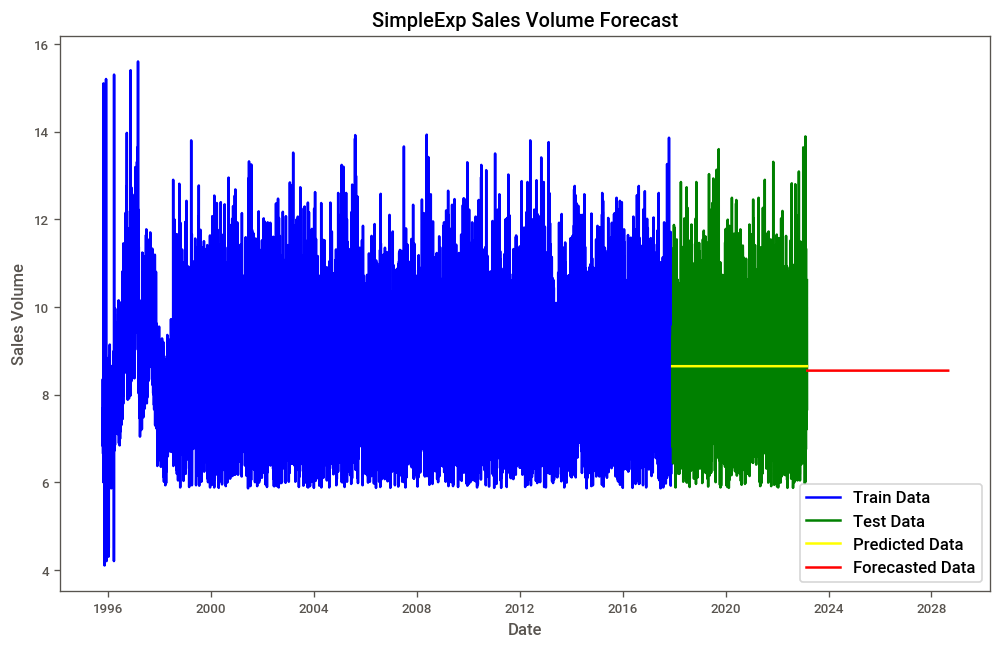

In [146]:
import matplotlib.pyplot as plt

# Plot train data in blue
plt.plot(train_data['Sales_volume'], color='blue', label='Train Data')

# Plot test data in green
plt.plot(test_data['Sales_volume'], color='green', label='Test Data')

# Plot forecasted values in yellow
plt.plot(pred_SimpleExp, color='yellow', label='Predicted Data')

# Plot forecasted values in red
plt.plot(forecast_SimpleExp, color='red', label='Forecasted Data')


# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.title('SimpleExp Sales Volume Forecast')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


# Model Evaluation

In [147]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [148]:
rmse = sqrt(mean_squared_error(test_data.Sales_volume, pred_ARIMA)) 
print('ARIMA_RMSE: %.3f' % rmse)
mape = sqrt(mean_absolute_error(test_data.Sales_volume, pred_ARIMA)*100)
print('ARIMA_MAPE: %.3f' % mape)

ARIMA_RMSE: 1.522
ARIMA_MAPE: 11.179


In [149]:
rmse = sqrt(mean_squared_error(test_data.Sales_volume, pred_SARIMA))
print('SARIMA RMSE: %.3f' % rmse)
mape = sqrt( mean_absolute_error(test_data.Sales_volume,pred_SARIMA)*100)
print('SARIMA MAPE: %.3f' % mape)

SARIMA RMSE: 2.016
SARIMA MAPE: 12.701


In [150]:
rmse = sqrt(mean_squared_error(test_data.Sales_volume, pred_SARIMAX))
print('SARIMAX_RMSE: %.3f' % rmse)
mape = sqrt( mean_absolute_error(test_data.Sales_volume,pred_SARIMAX)*100)
print('SARIMAX_MAPE: %.3f' % mape)

SARIMAX_RMSE: 1.550
SARIMAX_MAPE: 11.312


In [151]:
rmse = sqrt(mean_squared_error(test_data.Sales_volume, pred_SimpleExp))
print('SimpleExp_RMSE: %.3f' % rmse)
mape = sqrt( mean_absolute_error(test_data.Sales_volume,pred_SimpleExp)*100)
print('SimpleExp_MAPE: %.3f' % mape)

SimpleExp_RMSE: 1.522
SimpleExp_MAPE: 11.179


In [152]:
rmse = sqrt(mean_squared_error(test_data.Sales_volume, pred_AES)) 
print('AES_RMSE: %.3f' % rmse)
mape = sqrt( mean_absolute_error(test_data.Sales_volume,pred_AES)*100)
print('AES_MAPE: %.3f' % mape)

AES_RMSE: 1.523
AES_MAPE: 11.181


In [153]:
rmse = sqrt(mean_squared_error(test_data.Sales_volume, pred_MA))
print('MA_RMSE: %.3f' % rmse)
mape = sqrt( mean_absolute_error(test_data.Sales_volume,pred_MA)*100)
print('MA_MAPE: %.3f' % mape)

MA_RMSE: 1.552
MA_MAPE: 11.237


In [154]:
from tabulate import tabulate

table = [["Model", "RMSE", "MAPE"],
         ["ARIMA", "1.522", "11.179"],
         ["SARIMA", "2.016", "12.701"],
         ["SARIMAX", "1.550", "11.312"],
         ["SimpleExp", "1.522", "11.179"],
         ["AES", "1.523", "11.181"],
         ["MA", "1.552", "11.237"]]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

╒═══════════╤════════╤════════╕
│ Model     │   RMSE │   MAPE │
╞═══════════╪════════╪════════╡
│ ARIMA     │  1.522 │ 11.179 │
├───────────┼────────┼────────┤
│ SARIMA    │  2.016 │ 12.701 │
├───────────┼────────┼────────┤
│ SARIMAX   │  1.55  │ 11.312 │
├───────────┼────────┼────────┤
│ SimpleExp │  1.522 │ 11.179 │
├───────────┼────────┼────────┤
│ AES       │  1.523 │ 11.181 │
├───────────┼────────┼────────┤
│ MA        │  1.552 │ 11.237 │
╘═══════════╧════════╧════════╛


# Save the Best Model with Pickel library

In [155]:
import pickle

In [156]:
# Save the model
pickle.dump(model_Arima_fit, open('model_arima.pkl', 'wb'))

In [157]:
import os
os.getcwd()

'C:\\Users\\hp\\Desktop\\001 project code 2\\Code IPNB'

In [158]:
# Load the model
model = pickle.load(open('model_arima.pkl', 'rb'))

In [159]:
model

In [160]:
clean_data.to_csv('TMT_Steel_Data.csv')
os.getcwd()

'C:\\Users\\hp\\Desktop\\001 project code 2\\Code IPNB'